In [1]:
from my_func.read_model import nstpp_path
from my_func.read_model import *
from my_func.tpp_lambda import *
from my_func.cnf_prob import *
import my_datasets as datasets

import os, sys
if nstpp_path not in sys.path:
    sys.path.append(nstpp_path)
    
import matplotlib.pyplot as plt

In [2]:
%load_ext autoreload
%autoreload 2

In [59]:
# Matplotlib properties
plt.rcParams['axes.labelsize'] = 22
plt.rcParams['axes.titlesize'] = 22
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['legend.fontsize'] = 16
plt.rcParams["font.family"] = "Arial"

## Read model

In [4]:
# Directory for analysis
# result_path = './JP_no_mag/'
result_path = './JP_mag4_2dcnf/'
# result_path = './JP_mag4_3dcnf/'

# Read model checkpoint
checkpt = torch.load(os.path.join(result_path, 'model.pth'), "cpu")

# Read input arguments
args = read_arguments(os.path.join(result_path, 'logs'))

# Read train / validation / test log likelihood
train_loglik, val_loglik, test_loglik = read_loglik(os.path.join(result_path, 'logs'))

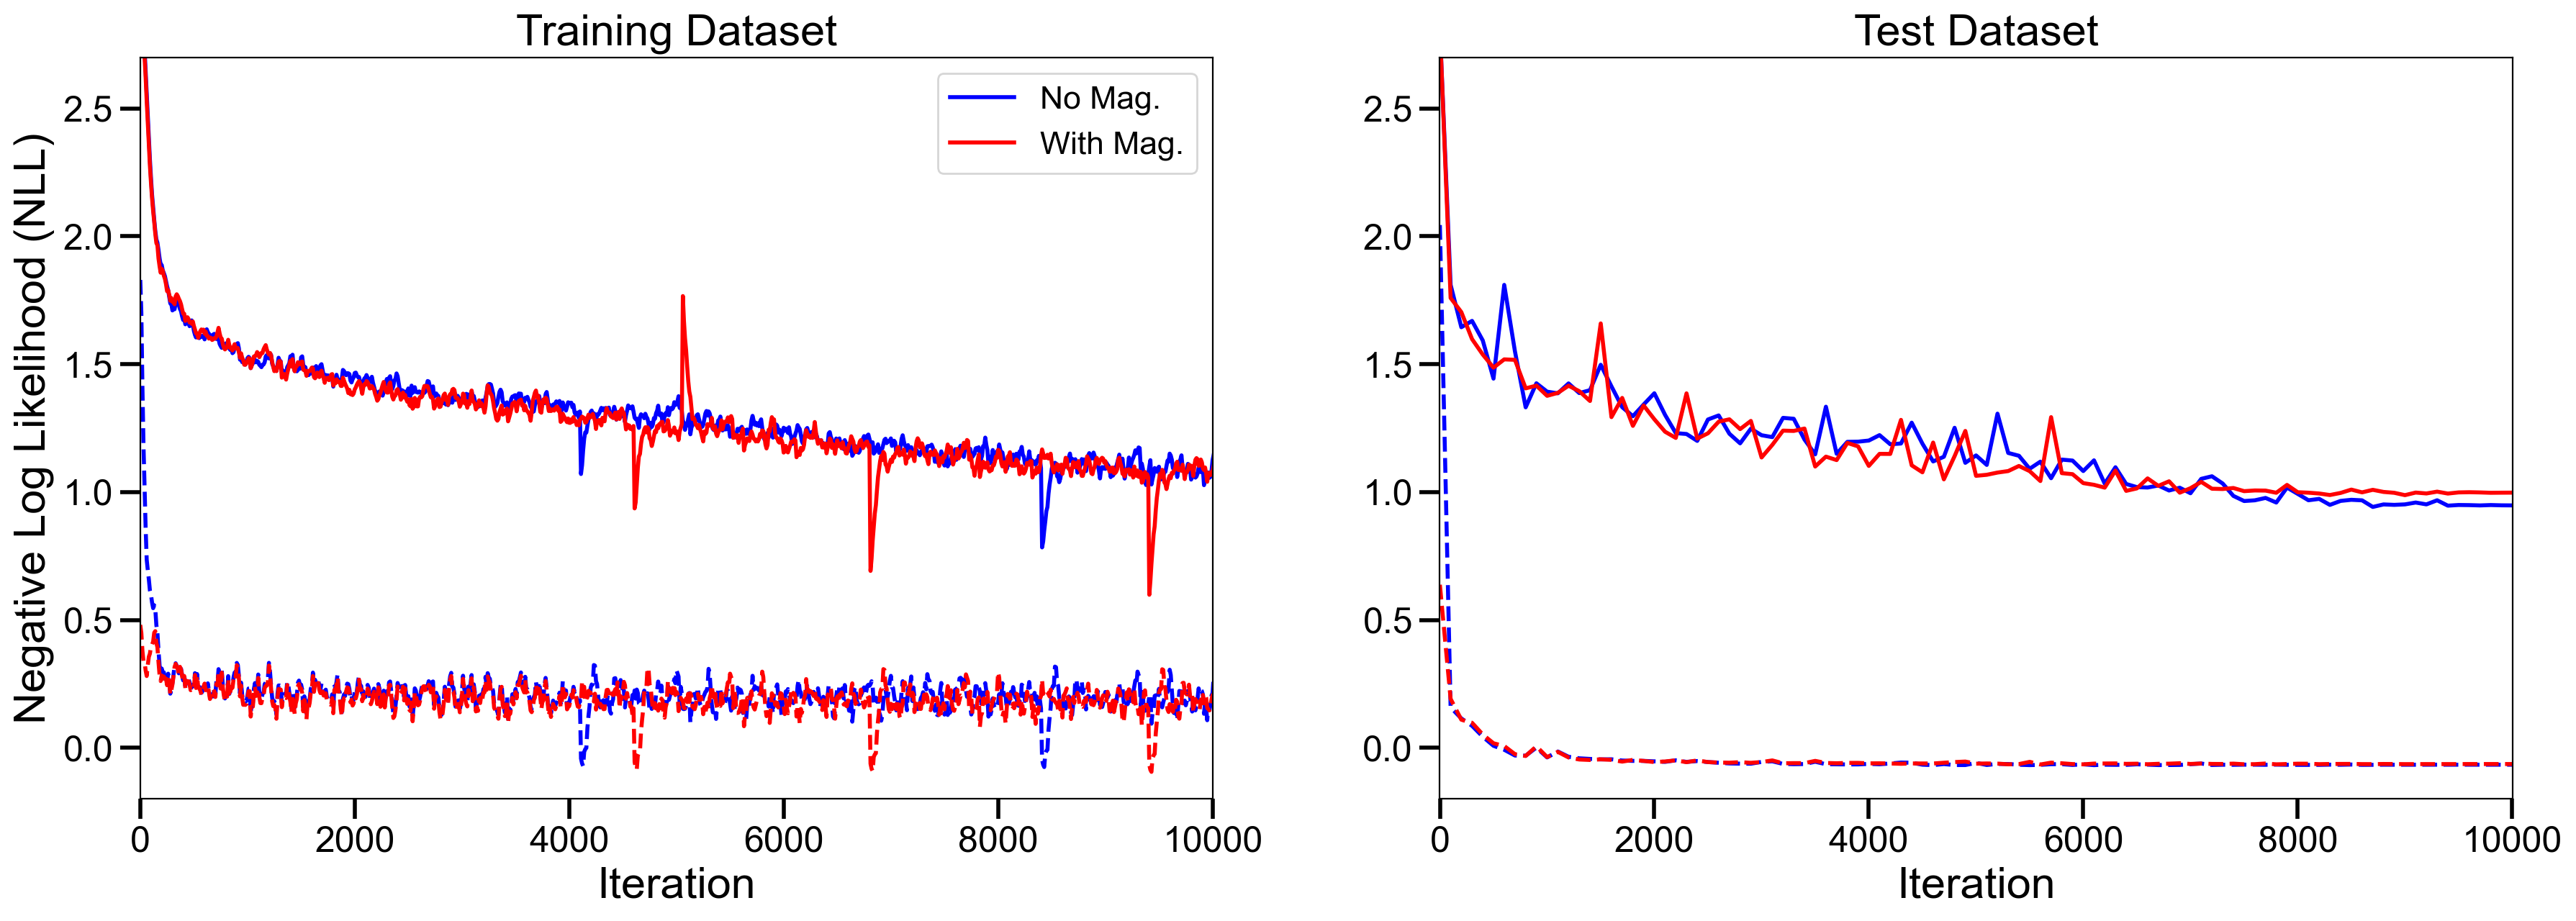

In [40]:
# Read train / validation / test log likelihood
train_loglik_no, val_loglik_no, test_loglik_no = read_loglik(os.path.join('./JP_no_mag/', 'logs'))
train_loglik_mag, val_loglik_mag, test_loglik_mag = read_loglik(os.path.join('./JP_mag4_2dcnf/', 'logs'))

plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['ytick.major.size'] = 10
plt.rcParams['ytick.major.width'] = 2

plt.rcParams['xtick.minor.size'] = 6
plt.rcParams['xtick.minor.width'] = 1.5
plt.rcParams['ytick.minor.size'] = 6
plt.rcParams['ytick.minor.width'] = 1.5

fig, axes = plt.subplots(1, 2, figsize=(18, 6.5), dpi=200)
axes[0].plot(train_loglik_no.iter, -train_loglik_no.temporal[:, 1], 'b--', linewidth=2)
axes[0].plot(train_loglik_no.iter, -train_loglik_no.spatial[:, 1], 'b-', linewidth=2, label='No Mag.')
axes[0].plot(train_loglik_mag.iter, -train_loglik_mag.temporal[:, 1], 'r--', linewidth=2)
axes[0].plot(train_loglik_mag.iter, -train_loglik_mag.spatial[:, 1], 'r-', linewidth=2, label='With Mag.')
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('Negative Log Likelihood (NLL)')
axes[0].set_title('Training Dataset')
axes[0].set_xlim([-1, 1e4+1])
axes[0].set_ylim([-0.2, 2.7])
axes[0].legend(loc='upper right')

axes[1].plot(test_loglik_no.iter, -test_loglik_no.temporal, 'b--', linewidth=2)
axes[1].plot(test_loglik_no.iter, -test_loglik_no.spatial, 'b-', linewidth=2, label='No Mag.')
axes[1].plot(test_loglik_mag.iter, -test_loglik_mag.temporal, 'r--', linewidth=2)
axes[1].plot(test_loglik_mag.iter, -test_loglik_mag.spatial, 'r-', linewidth=2, label='With Mag.')
axes[1].set_xlabel('Iteration')
# axes[1].set_ylabel('Negative Log Likelihood (NLL)')
axes[1].set_title('Test Dataset')
axes[1].set_xlim([-1, 1e4+1])
axes[1].set_ylim([-0.2, 2.7])

plt.tight_layout(w_pad=5)
plt.savefig('./Figures/NLL.png', dpi=200, bbox_inches='tight', pad_inches=0.05)

In [7]:
# Spatial dimension of CNF
if result_path == './JP_mag4_3dcnf/':
    args.spatial_dim = 3
else:
    args.spatial_dim = 2

# Load parameters from checkpoint file
model = create_model(args)
model.load_state_dict(checkpt["state_dict"])
model.eval()

# Temporal & CNF model
tpp_model = model.temporal_model
cnf_model = model.spatial_model

In [8]:
# Model configuration
model

SelfAttentiveCNFSpatiotemporalModel(
  (temporal_model): NeuralPointProcess(
    (hidden_state_dynamics): HiddenStateODEFuncList(
      (odefuncs): ModuleList(
        (0): GRUHiddenStateODEFunc(
          (dstate_net): SequentialDiffEq(
            (layers): ModuleList(
              (0): ConcatLinear_v2(
                (_layer): Linear(in_features=32, out_features=32, bias=True)
                (_hyper_bias): Linear(in_features=1, out_features=32, bias=False)
              )
              (1): ActNorm(32)
              (2): Softplus(beta=1, threshold=20)
              (3): ConcatLinear_v2(
                (_layer): Linear(in_features=32, out_features=32, bias=True)
                (_hyper_bias): Linear(in_features=1, out_features=32, bias=False)
              )
            )
          )
          (update_net): GRUCell(3, 32)
        )
      )
    )
    (ode_solver): TimeVariableODE(
      method=dopri5, atol=0.0001, rtol=0.0001, energy=0.0001
      (func): IntensityODEFunc(
        

## Read dataset

In [42]:
# Start & End time, Interval [0,T)
t0, t1 = map(lambda x: cast(x, device), get_t0_t1(args.data))

# File to load
npz_file = os.path.join('./data/eq_JP_m4.0.npz')
print(f'Read data: {npz_file}')

# Read dataset
dataset = datasets.Earthquakes(split="train", npz_file=npz_file)

Read data: ./data/eq_JP_m4.0.npz


In [43]:
# Sequence length statistics
seq_len = []
for obj in dataset:
    seq_len.append(obj.shape[0])
seq_len = np.array(seq_len)

print(f'Max length sequence: index {np.argmax(seq_len)}, length {np.max(seq_len)}')
print(f'Number of sequence: {len(seq_len)}')
print(f'Total number of events: {np.sum(seq_len)}')

Max length sequence: index 342, length 251
Number of sequence: 950
Total number of events: 59868


In [12]:
# Magnitude statistics
eq_max_mag = []
for obj in dataset:
    eq_max_mag.append(obj[:,3].max().numpy())
eq_max_mag = np.array(eq_max_mag) * dataset.S_std[0, 2].numpy() + dataset.S_mean[0, 2].numpy()

print(f'Max magnitude: index {np.argmax(eq_max_mag)}, magnitude {np.max(eq_max_mag)}')

eq_mag = np.array([])
for obj in dataset:
    eq_mag = np.concatenate((eq_mag, obj[:,3]))
    
eq_mag = eq_mag * dataset.S_std[0,2].numpy() + dataset.S_mean[0,2].numpy()
print(f'Magnitude range: {eq_mag.min()}, {eq_mag.max()}')

Max magnitude: index 449, magnitude 8.16
Magnitude range: 4.1, 8.16


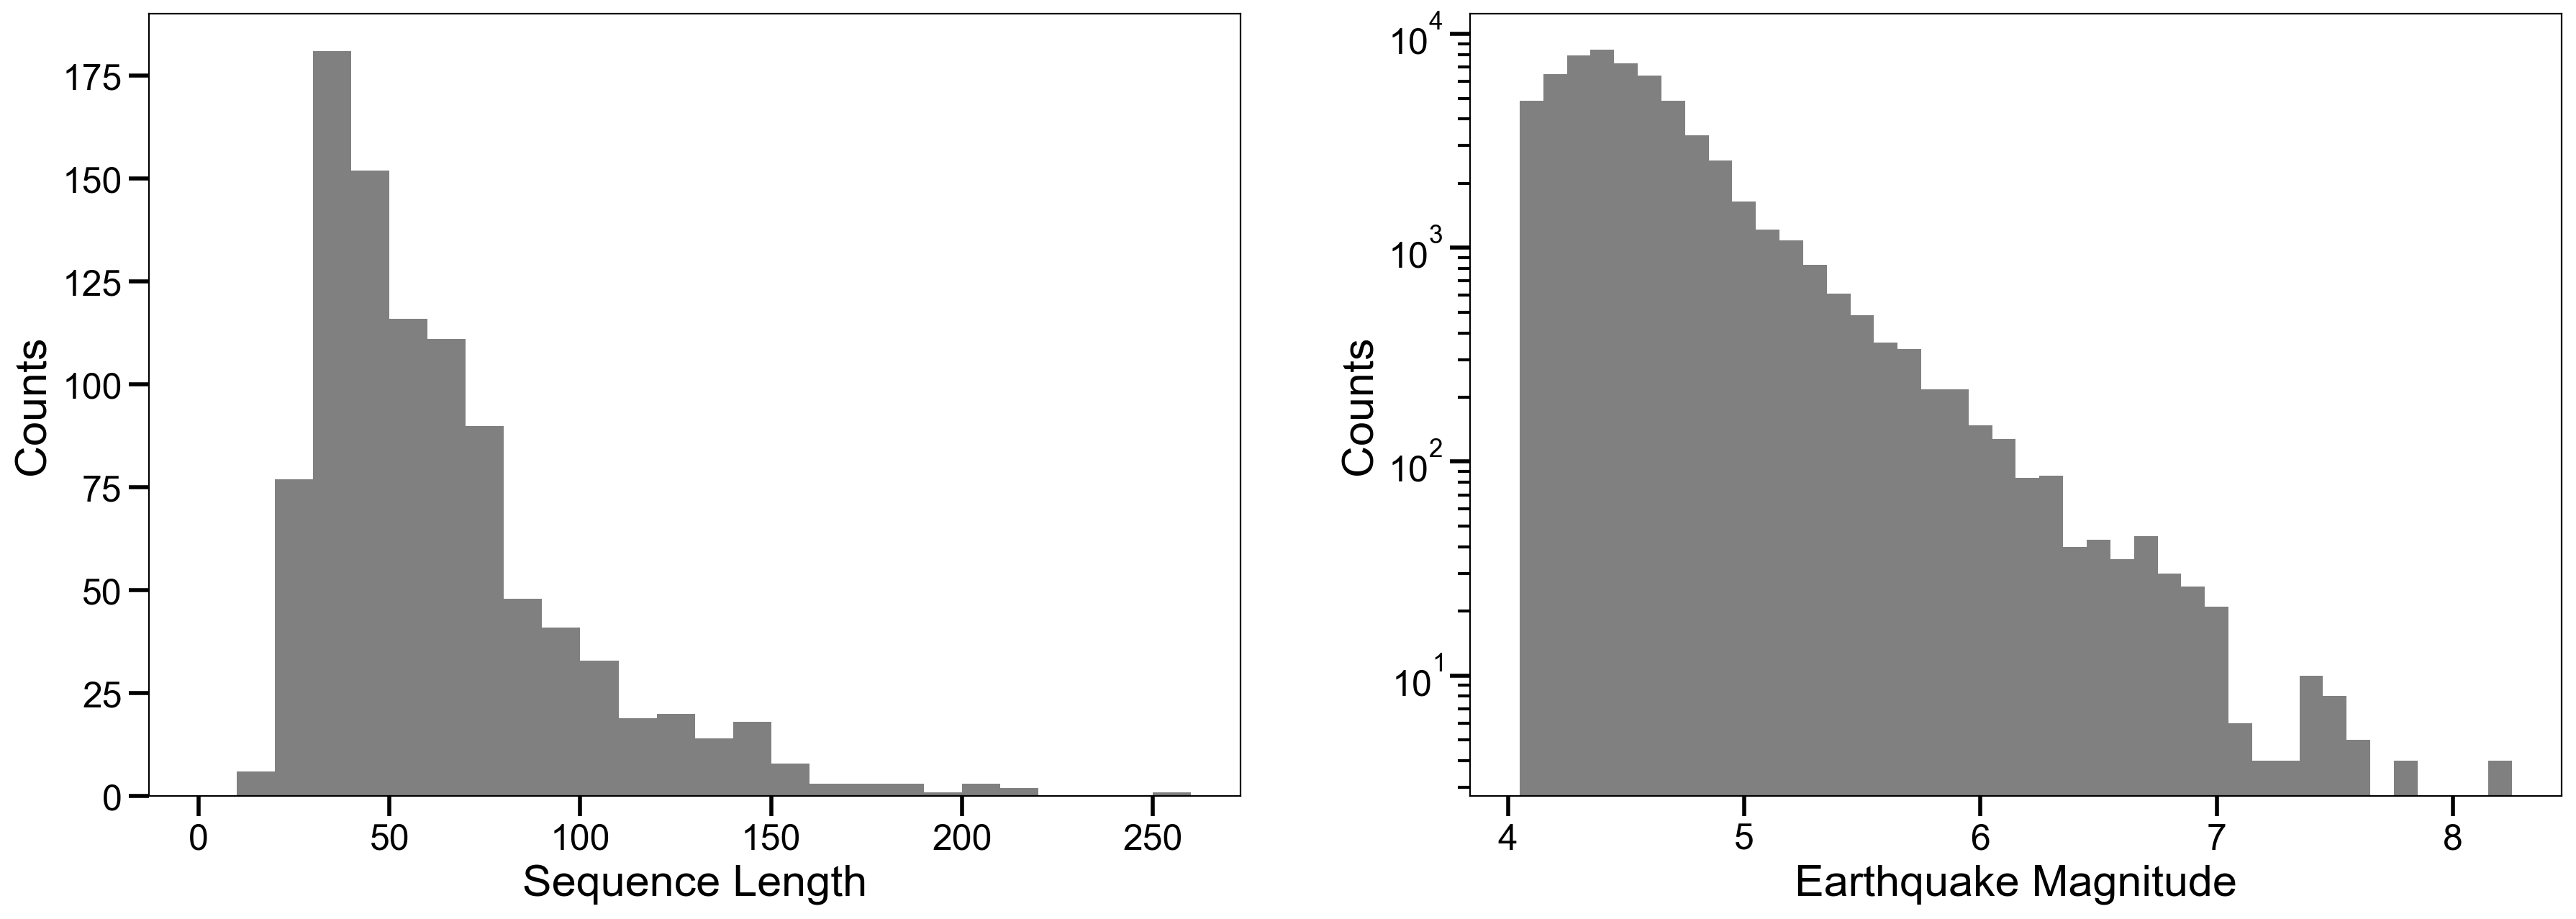

In [39]:
bin_width = 10
bins = np.arange(0, max(seq_len) + bin_width, bin_width)

fig, axes = plt.subplots(1, 2, figsize=(18, 6.5), dpi=200)
axes[0].hist(seq_len, bins=bins, color='gray', alpha=1, edgecolor=None)
axes[0].set_xlabel('Sequence Length')
axes[0].set_ylabel('Counts')

bin_width = 0.1
bins = np.arange(eq_mag.min() - bin_width/2, eq_mag.max() + bin_width, bin_width)

axes[1].hist(eq_mag, bins=bins, color='gray', alpha=1, edgecolor=None)
axes[1].set_xlabel('Earthquake Magnitude')
axes[1].set_ylabel('Counts')
axes[1].set_yscale('log')

plt.tight_layout(w_pad=5)
fig.savefig('./Figures/stats.png', dpi=200, bbox_inches='tight', pad_inches=0.05)

## Create temporal intensity database

In [110]:
all_times = []
all_locs = []
all_mags = []
all_pre_lambdas = []
all_post_lambdas = []

for i in range(950):
    
    if (i+1) % 10 == 0:
        print(i+1)
    
    seq = dataset.__getitem__(i)
    event_times = cast(seq[:, 0], device)
    tpp_locations = cast(seq[:, 1:tpp_model.cond_dim+1], device)
    
    # Event location
    event_locations = cast(seq[:, 1:3], device)
    real_event_locs = event_locations * dataset.S_std[0, :2] + dataset.S_mean[0, :2]
    
    event_mags = cast(seq[:, 3], device)
    real_event_mags = event_mags * dataset.S_std[0, 2] + dataset.S_mean[0, 2]
    
    all_times.append(to_numpy(event_times))
    all_locs.append(to_numpy(real_event_locs))
    all_mags.append(to_numpy(real_event_mags))
    
    intensities, _, _, _ = get_intensities(tpp_model, event_times, tpp_locations, t0, t1, 0)
    
    pre_lambdas = intensities[:-1, 1]
    post_lambdas = intensities[1:, 0]
    
    all_pre_lambdas.append(to_numpy(pre_lambdas))
    all_post_lambdas.append(to_numpy(post_lambdas))
    
    if i == 499:
        all_times = np.concatenate(all_times)
        all_locs = np.concatenate(all_locs, axis=0)
        all_mags = np.concatenate(all_mags)
        all_pre_lambdas = np.concatenate(all_pre_lambdas)
        all_post_lambdas = np.concatenate(all_post_lambdas)
        
        # np.savez(f'{result_path}/lambda_train_1.npz', all_times=all_times, all_locs=all_locs,
        #          all_mags=all_mags, all_pre_lambdas=all_pre_lambdas, all_post_lambdas=all_post_lambdas)
        
        all_times = []
        all_locs = []
        all_mags = []
        all_pre_lambdas = []
        all_post_lambdas = []
        
all_times = np.concatenate(all_times)
all_locs = np.concatenate(all_locs, axis=0)
all_mags = np.concatenate(all_mags)
all_pre_lambdas = np.concatenate(all_pre_lambdas)
all_post_lambdas = np.concatenate(all_post_lambdas)

# np.savez(f'{result_path}/lambda_train_2.npz', all_times=all_times, all_locs=all_locs,
#          all_mags=all_mags, all_pre_lambdas=all_pre_lambdas, all_post_lambdas=all_post_lambdas)

10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950


In [107]:
all_times = []
all_locs = []
all_mags = []
all_pre_lambdas = []
all_post_lambdas = []

for i in range(50):
    
    if (i+1) % 10 == 0:
        print(i+1)
    
    seq = dataset.__getitem__(i)
    event_times = cast(seq[:, 0], device)
    tpp_locations = cast(seq[:, 1:tpp_model.cond_dim+1], device)
    
    # Event location
    event_locations = cast(seq[:, 1:3], device)
    real_event_locs = event_locations * dataset.S_std[0, :2] + dataset.S_mean[0, :2]
    
    event_mags = cast(seq[:, 3], device)
    real_event_mags = event_mags * dataset.S_std[0, 2] + dataset.S_mean[0, 2]
    
    all_times.append(to_numpy(event_times))
    all_locs.append(to_numpy(real_event_locs))
    all_mags.append(to_numpy(real_event_mags))
    
    intensities, _, _, _ = get_intensities(tpp_model, event_times, tpp_locations, t0, t1, 0)
    
    pre_lambdas = intensities[:-1, 1]
    post_lambdas = intensities[1:, 0]
    
    all_pre_lambdas.append(to_numpy(pre_lambdas))
    all_post_lambdas.append(to_numpy(post_lambdas))
        
all_times = np.concatenate(all_times)
all_locs = np.concatenate(all_locs, axis=0)
all_mags = np.concatenate(all_mags)
all_pre_lambdas = np.concatenate(all_pre_lambdas)
all_post_lambdas = np.concatenate(all_post_lambdas)

# np.savez(f'{result_path}/lambda_test.npz', all_times=all_times, all_locs=all_locs,
#          all_mags=all_mags, all_pre_lambdas=all_pre_lambdas, all_post_lambdas=all_post_lambdas)

10
20
30
40
50


## Analyze temporal jumps

In [67]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def stretch_array(arr, a, b):
    
    # Min-max normalization to the range [a, b]
    min_val = np.min(arr)
    max_val = np.max(arr)
    
    new_arr = a + ((arr - min_val) * (b - a)) / (max_val - min_val)
    return new_arr

In [56]:
# Read analyzed data
all_times, all_locs, all_mags, all_pre_lambdas, all_post_lambdas = read_lambda_npz(
    [f'{result_path}/lambda_train_1.npz', f'{result_path}/lambda_train_2.npz',
     f'{result_path}/lambda_val.npz', f'{result_path}/lambda_test.npz'])

In [57]:
# Size of dots
all_sizes = stretch_array(all_mags, -1, 1)
all_sizes = (10 ** all_sizes) ** 2

# Order of plotting dots
all_sorted = np.argsort(all_sizes)

(-15.0, 50.0)

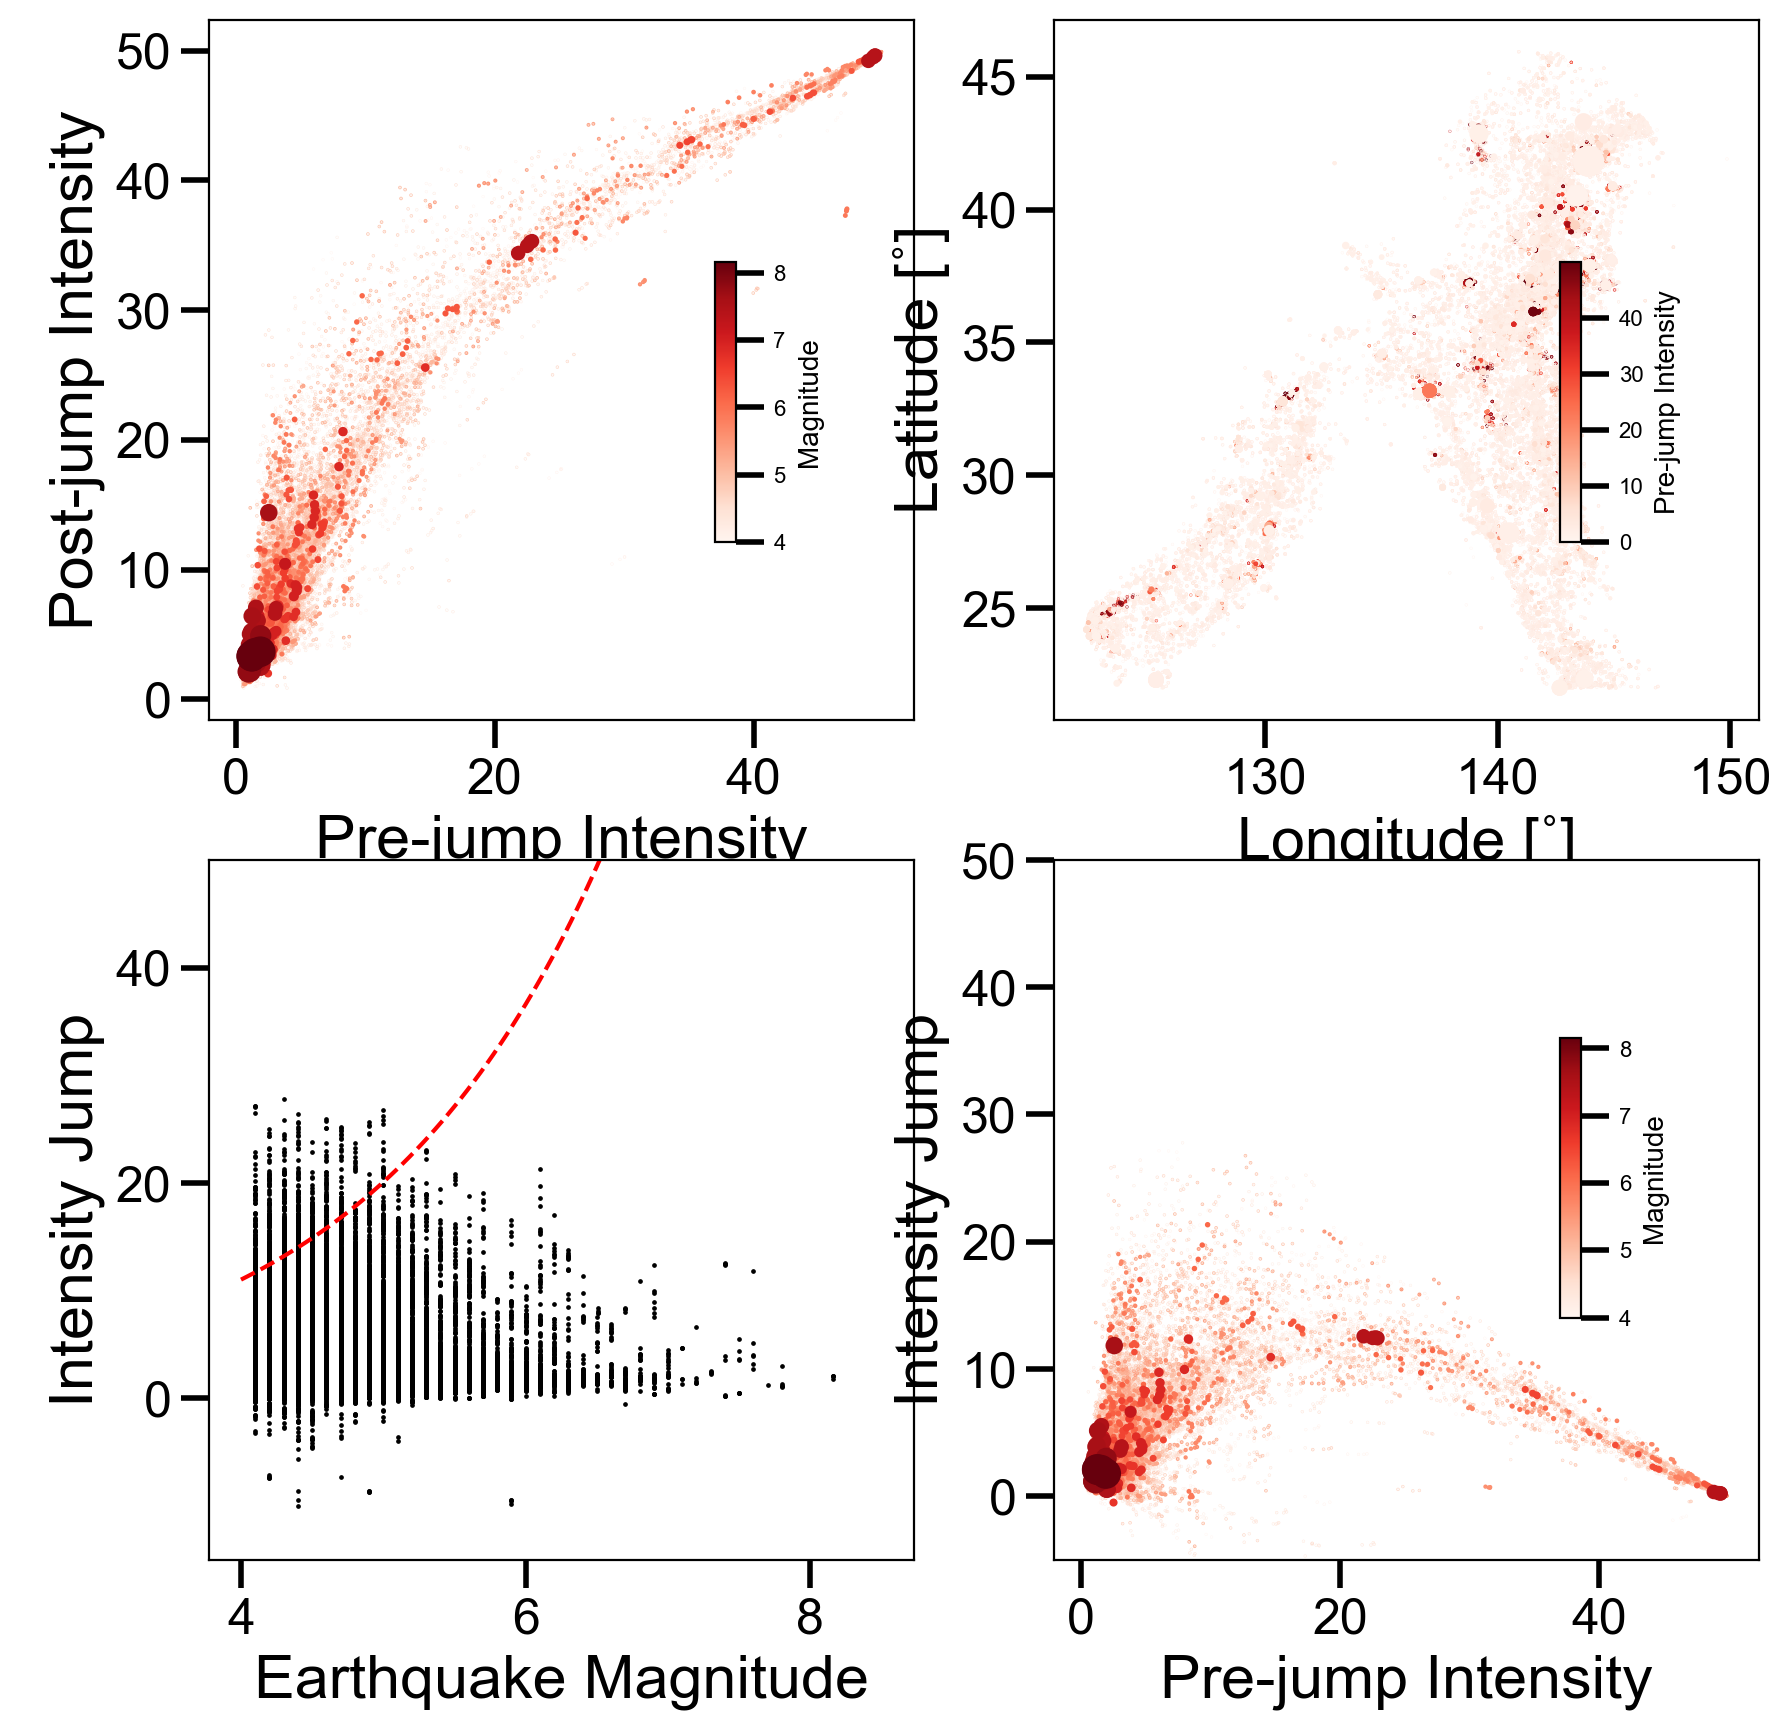

In [58]:
fig, axes = plt.subplots(2, 2, figsize=(10,10), dpi=200)
obj1 = axes[0,0].scatter(all_pre_lambdas[all_sorted], all_post_lambdas[all_sorted], 
                         s=all_sizes[all_sorted], c=all_mags[all_sorted], cmap='Reds', vmin=4.0)
axes[0,0].set_xlabel('Pre-jump Intensity')
axes[0,0].set_ylabel('Post-jump Intensity')
axes[0,0].grid(False)

cax = inset_axes(axes[0, 0], width="3%", height="40%", loc='lower right', borderpad=4)
cbar = fig.colorbar(obj1, cax=cax, orientation='vertical')
cbar.set_label('Magnitude', fontsize=10)
cbar.ax.tick_params(labelsize=8)


obj2 = axes[0,1].scatter(all_locs[all_sorted, 0], all_locs[all_sorted, 1], 
                         s=all_sizes[all_sorted], c=all_pre_lambdas[all_sorted], cmap='Reds', vmin=0)
axes[0,1].set_xlabel('Longitude [˚]')
axes[0,1].set_ylabel('Latitude [˚]')
axes[0,1].grid(False)

cax = inset_axes(axes[0, 1], width="3%", height="40%", loc='lower right', borderpad=4)
cbar = fig.colorbar(obj2, cax=cax, orientation='vertical')
cbar.set_label('Pre-jump Intensity', fontsize=10)
cbar.ax.tick_params(labelsize=8)

axes[1,0].scatter(all_mags, all_post_lambdas-all_pre_lambdas, s=0.5, c='k')
axes[1,0].set_xlabel('Earthquake Magnitude')
axes[1,0].set_ylabel('Intensity Jump')
axes[1,0].grid(False)

obj4 = axes[1,1].scatter(all_pre_lambdas[all_sorted], (all_post_lambdas-all_pre_lambdas)[all_sorted], 
                  s=all_sizes[all_sorted], c=all_mags[all_sorted], cmap='Reds', vmin=4.0)
axes[1,1].set_xlabel('Pre-jump Intensity')
axes[1,1].set_ylabel('Intensity Jump')
axes[1,1].grid(False)
axes[1,1].set_ylim([-5, 50])

cax = inset_axes(axes[1, 1], width="3%", height="40%", loc='upper right', borderpad=4)
cbar = fig.colorbar(obj4, cax=cax, orientation='vertical')
cbar.set_label('Magnitude', fontsize=10)
cbar.ax.tick_params(labelsize=8)

# K factor in Omori law
alpha = 0.6
mag_lin = np.linspace(4, 8.5, 100)
K = np.exp(alpha * mag_lin)
axes[1,0].plot(mag_lin, K, 'r--', linewidth=1.5)
axes[1,0].set_ylim([-15, 50])

# Select one sequence for analysis

In [30]:
# Select sequence to analysis
index = 600  # 640, 342 (max len), 449 (max mag)
seq = dataset.__getitem__(index)

# T: sequence length, D: data dimension
T, D = seq.shape
D = D - 1

# Event time
event_times = cast(seq[:, 0], device)

# Event location
event_locations = cast(seq[:, 1:3], device)
real_event_locs = event_locations * dataset.S_std[0, :2] + dataset.S_mean[0, :2]

# Event magnitude
if D == 3:
    event_mags = cast(seq[:, 3], device)
    real_event_mags = event_mags * dataset.S_std[0, 2] + dataset.S_mean[0, 2]  
else:
    event_mags, real_event_mags = None, None
    
# TPP conditional input data
tpp_locations = cast(seq[:, 1:tpp_model.cond_dim+1], device)

print(f'Sequence length: {T}')

Sequence length: 71


## Temporal intensity

In [178]:
# Create time samples
npts_interval = 18
time_samples = create_time_samples(event_times, t0, t1, npts_interval)

# Get temporal intensities
intensities, Lambdas, prejump_hidden_states, postjump_hidden_states = get_intensities(
    tpp_model, event_times, tpp_locations, t0, t1, npts_interval)
intensities = to_numpy(intensities)

(20.0, 30.0)

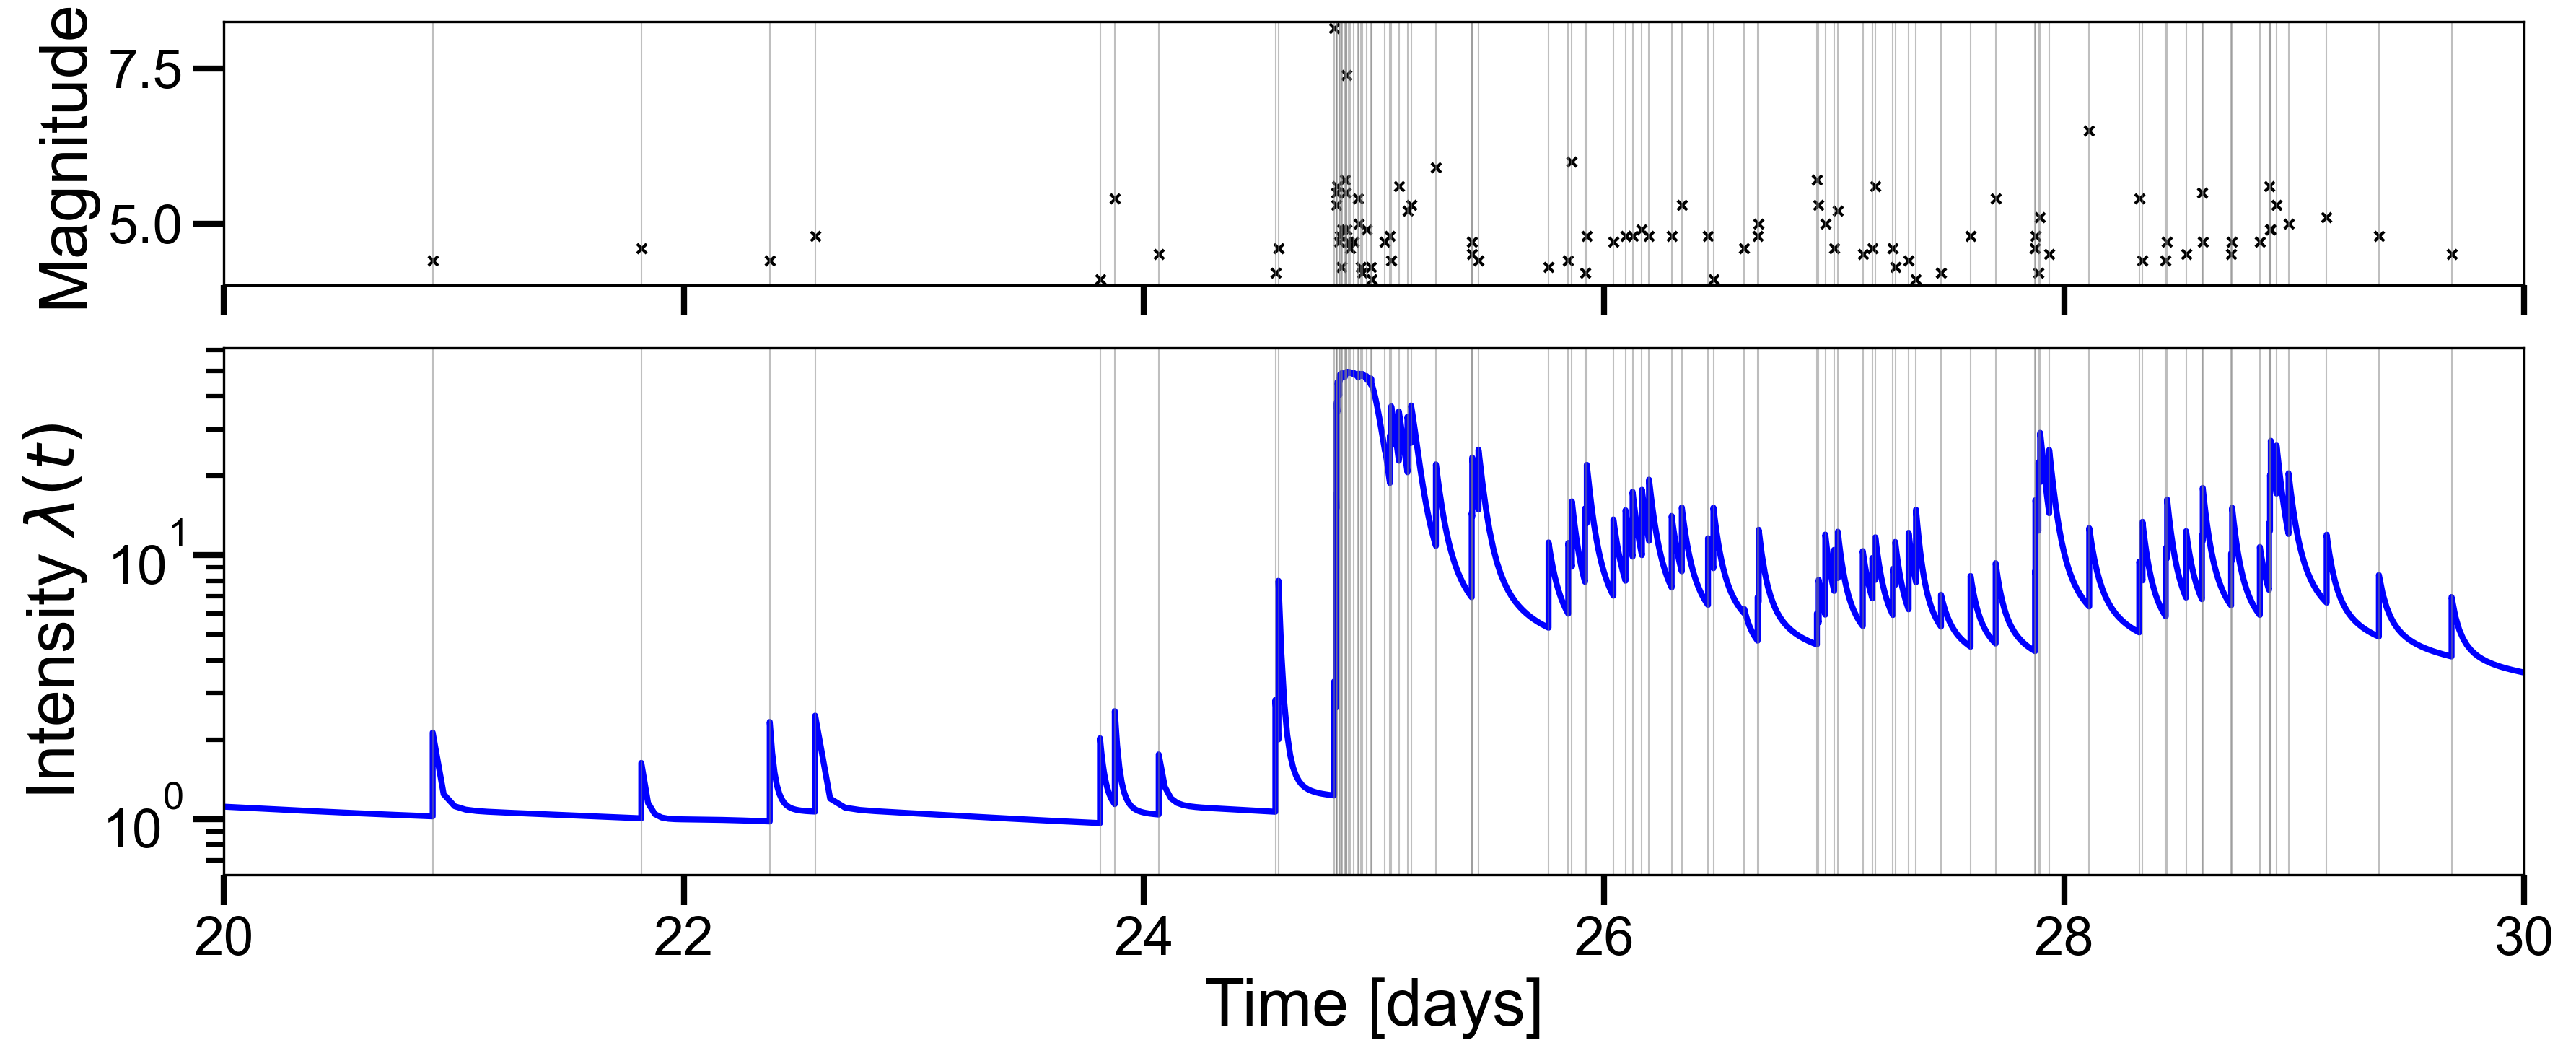

In [173]:
# fig, axes = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [1, 2]}, figsize=(12,5), dpi=300)
axes[0].scatter(event_times, real_event_mags, 10, c='k', marker='x', linewidth=1)
axes[0].set_ylabel('Magnitude')
axes[0].set_ylim([4.0, real_event_mags.max()+0.1])

axes[1].semilogy(time_samples.reshape(-1), intensities.reshape(-1), 'b-', lw=2)
axes[1].set_xlim([t0, t1])
axes[1].set_xlabel('Time [days]')
axes[1].set_ylabel('Intensity $\lambda(t)$')
plt.tight_layout()

for ti in event_times:
    axes[0].axvline(x=ti, color='gray', linestyle='-', alpha=0.5, linewidth=0.5)
    axes[1].axvline(x=ti, color='gray', linestyle='-', alpha=0.5, linewidth=0.5)
axes[0].set_xlim([20, 30])

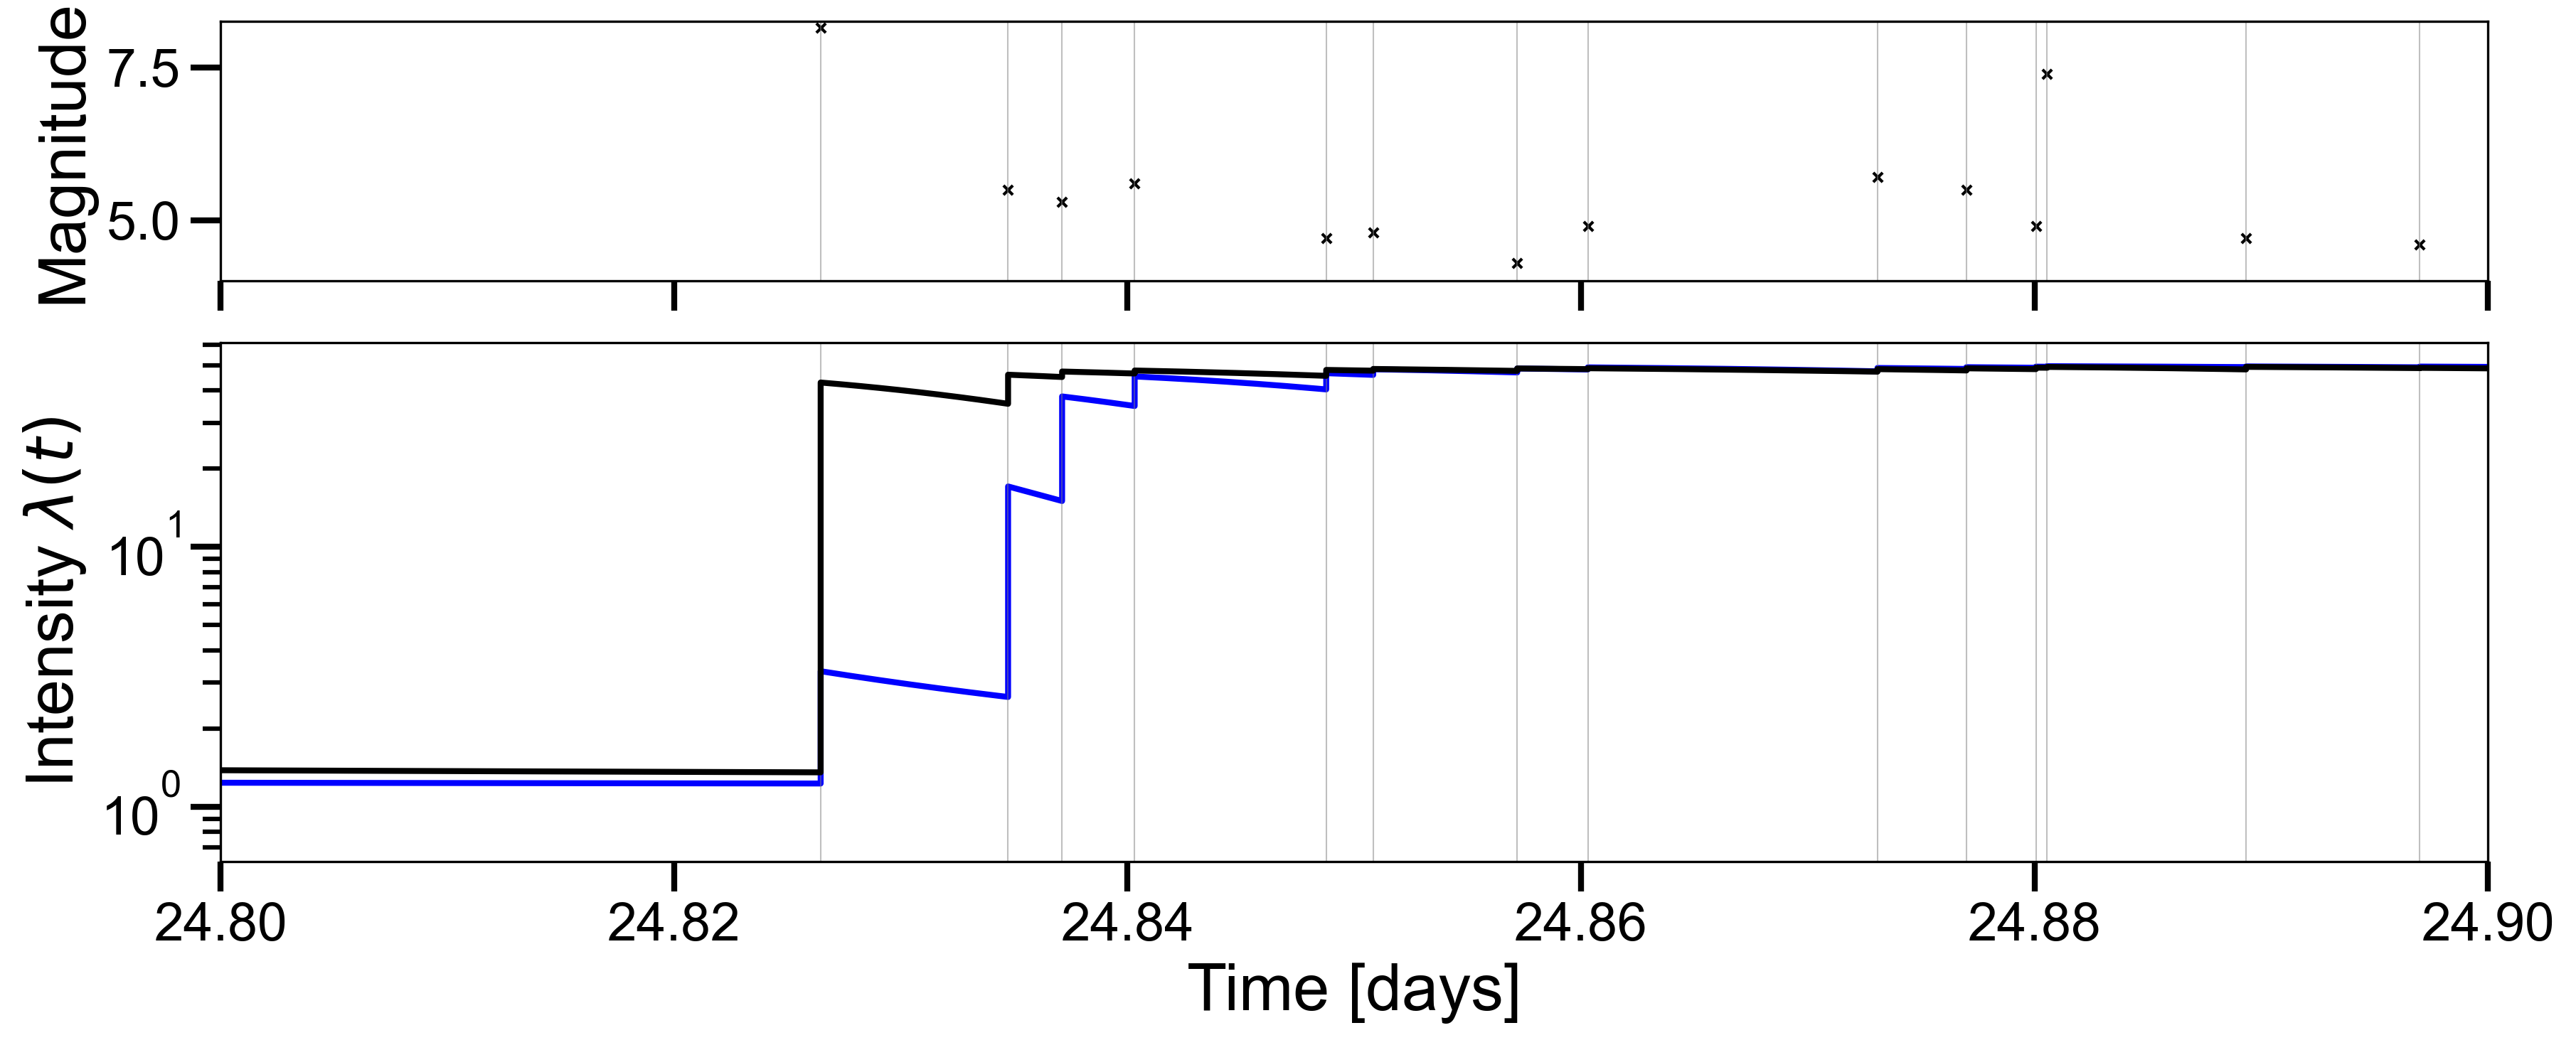

In [185]:
# axes[1].semilogy(time_samples.reshape(-1), intensities.reshape(-1), 'k-', lw=2)
axes[0].set_xlim([24.8, 24.9])
fig

## Compare temporal intensity

In [44]:
# Read first model
checkpt = torch.load(os.path.join('./JP_no_mag/', 'model.pth'), "cpu")
args = read_arguments(os.path.join('./JP_no_mag/', 'logs'))
model = create_model(args)
model.load_state_dict(checkpt["state_dict"])
model.eval()
tpp_model_no_mag = model.temporal_model

# Read second model
checkpt = torch.load(os.path.join('./JP_mag4_2dcnf/', 'model.pth'), "cpu")
args = read_arguments(os.path.join('./JP_mag4_2dcnf/', 'logs'))
model = create_model(args)
model.load_state_dict(checkpt["state_dict"])
model.eval()
tpp_model_with_mag = model.temporal_model

In [45]:
# Select sequence to analysis
index = 200  # 640, 342 (max len), 449 (max mag), 200 (good to see diff.)
seq = dataset.__getitem__(index)

# T: sequence length, D: data dimension
T, D = seq.shape
D = D - 1

# Event time
event_times = cast(seq[:, 0], device)

# Event location
event_locations = cast(seq[:, 1:3], device)
real_event_locs = event_locations * dataset.S_std[0, :2] + dataset.S_mean[0, :2]

# Event magnitude
if D == 3:
    event_mags = cast(seq[:, 3], device)
    real_event_mags = event_mags * dataset.S_std[0, 2] + dataset.S_mean[0, 2]  
else:
    event_mags, real_event_mags = None, None
    
# TPP conditional input data
tpp_locs_no_mag = cast(seq[:, 1:tpp_model_no_mag.cond_dim+1], device)
tpp_locs_with_mag = cast(seq[:, 1:tpp_model_with_mag.cond_dim+1], device)

print(f'Sequence length: {T}')

Sequence length: 29


In [46]:
# Create time samples
npts_interval = 18
time_samples = create_time_samples(event_times, t0, t1, npts_interval)

# Get temporal intensities
intensities, _, _, _ = get_intensities(
    tpp_model_no_mag, event_times, tpp_locs_no_mag, t0, t1, npts_interval)
intensities_no_mag = to_numpy(intensities)

intensities, _, _, _ = get_intensities(
    tpp_model_with_mag, event_times, tpp_locs_with_mag, t0, t1, npts_interval)
intensities_with_mag = to_numpy(intensities)

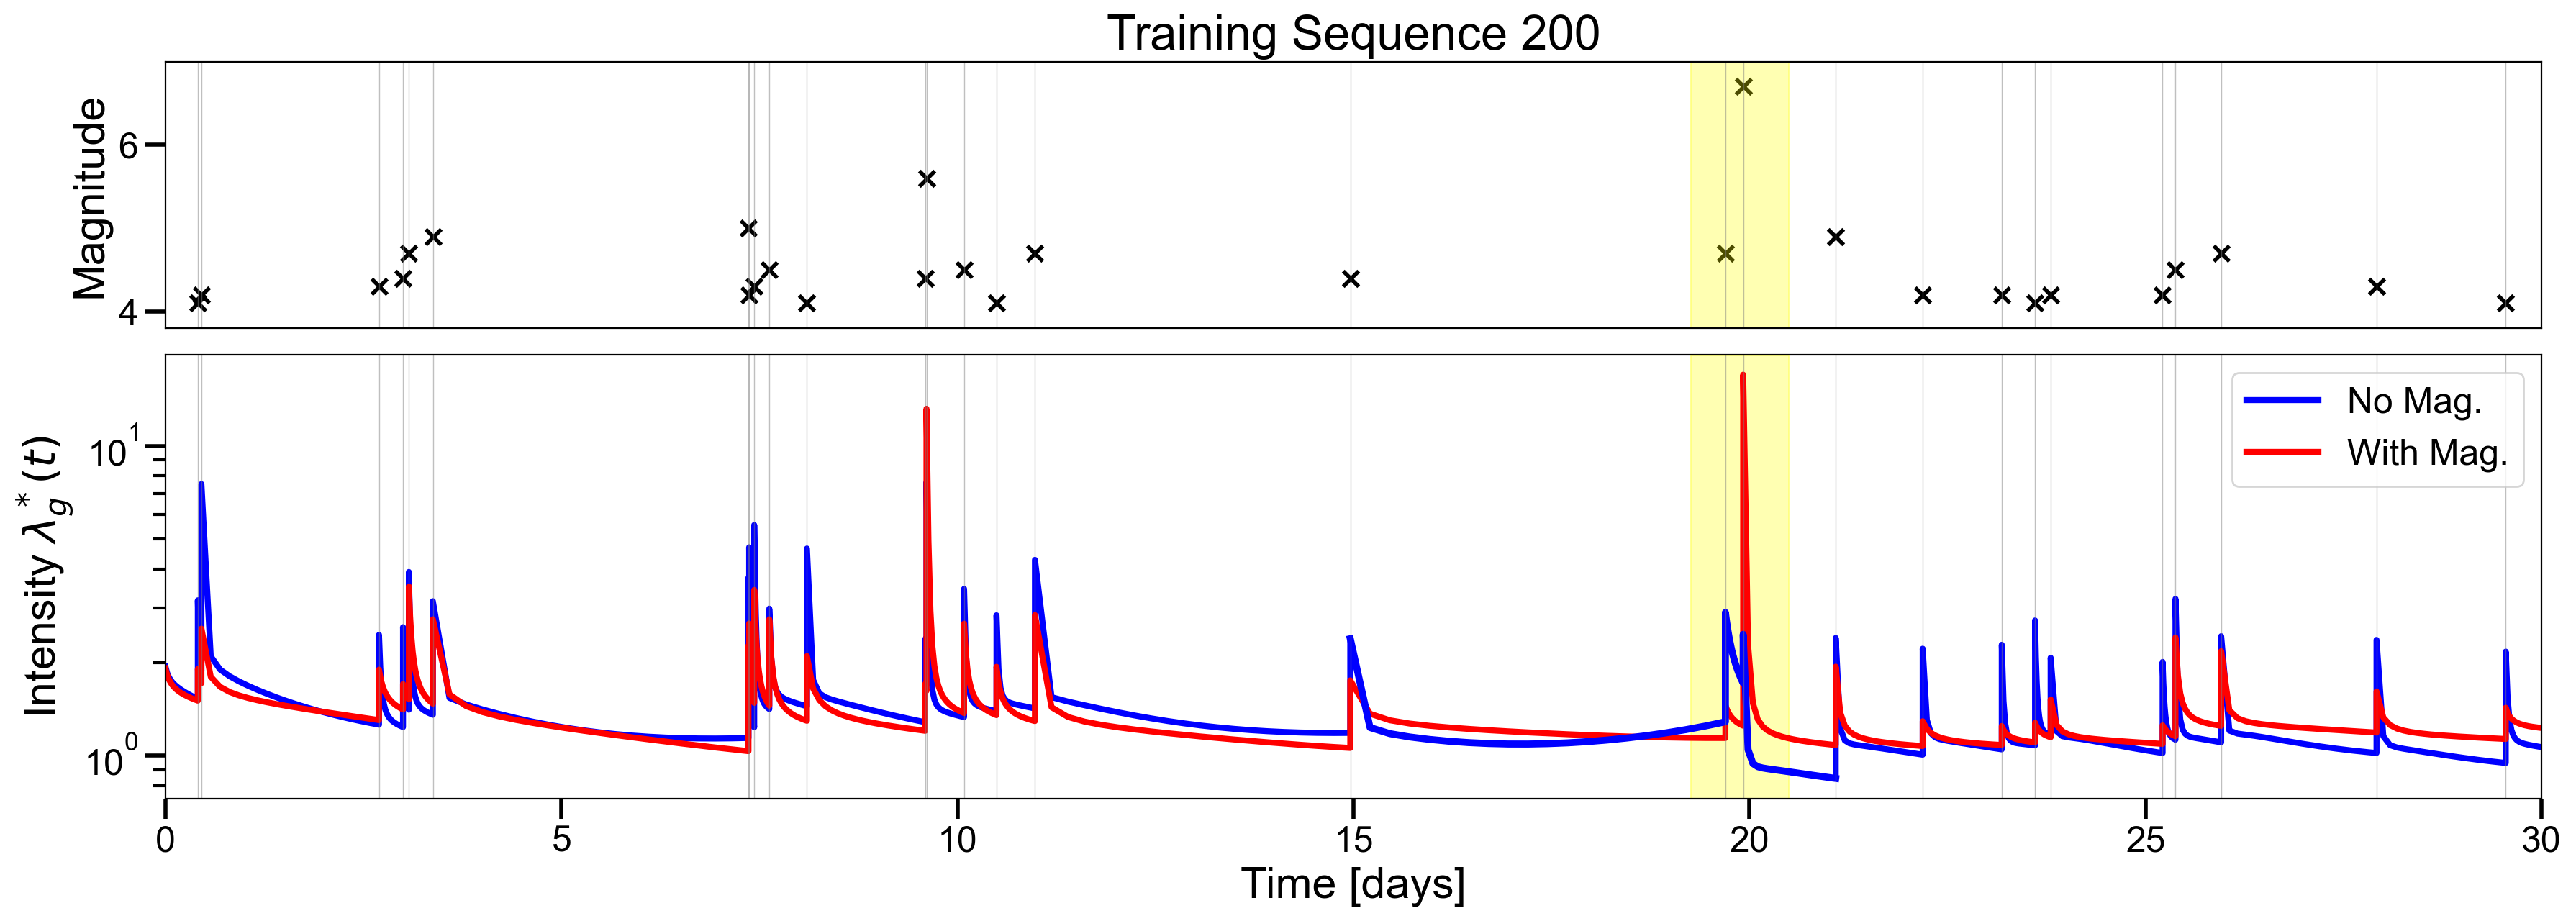

In [65]:
fig, axes = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [1.2, 2]}, figsize=(18,6.5), dpi=200)
axes[0].scatter(event_times, real_event_mags, 60, c='k', marker='x', linewidth=2)
axes[0].set_ylabel('Magnitude')
axes[0].set_ylim([4.0, real_event_mags.max()+0.1])
axes[0].set_ylim([3.8, 7.0])
axes[0].tick_params(axis='x', which='both', length=0)

axes[1].semilogy(time_samples.reshape(-1), intensities_no_mag.reshape(-1), 'b-', lw=3, label='No Mag.')
axes[1].semilogy(time_samples.reshape(-1), intensities_with_mag.reshape(-1), 'r-', lw=3, label='With Mag.')
axes[1].set_xlim([t0, t1])
axes[1].set_xlabel('Time [days]')
axes[1].plot(time_samples[17:20, :].reshape(-1), intensities_no_mag[17:20, :].reshape(-1), 'b-', lw=3.5)
axes[1].set_ylabel('Intensity $\lambda_g^*(t)$')

for ti in event_times:
    axes[0].axvline(x=ti, color='gray', linestyle='-', alpha=0.5, linewidth=0.5)
    axes[1].axvline(x=ti, color='gray', linestyle='-', alpha=0.5, linewidth=0.5)
    
axes[0].axvspan(19.25, 20.5, alpha=0.3, color='yellow', zorder=1)
axes[1].axvspan(19.25, 20.5, alpha=0.3, color='yellow', zorder=1)
axes[0].set_title(f'Training Sequence {index}', fontsize=24)
axes[1].legend(loc='upper right', fontsize=18)

# axes[0].set_xlim(0,5)
plt.tight_layout()
# fig.savefig('./Figures/intensity_200.png', dpi=200, bbox_inches='tight', pad_inches=0.05)

## Temporal jumps & Magnitude

In [93]:
# Read analyzed data
cur_path = './JP_no_mag/'
# cur_path = './JP_mag4_2dcnf/'

all_times, all_locs, all_mags, all_pre_lambdas, all_post_lambdas = read_lambda_npz(
    [f'{cur_path}/lambda_train_1.npz', f'{cur_path}/lambda_train_2.npz',
     f'{cur_path}/lambda_val.npz', f'{cur_path}/lambda_test.npz'])

# Size of dots
all_sizes = stretch_array(all_mags, -0.6, 1.4)
all_sizes = (10 ** all_sizes) ** 2

# Order of plotting dots
all_sorted = np.argsort(all_sizes)

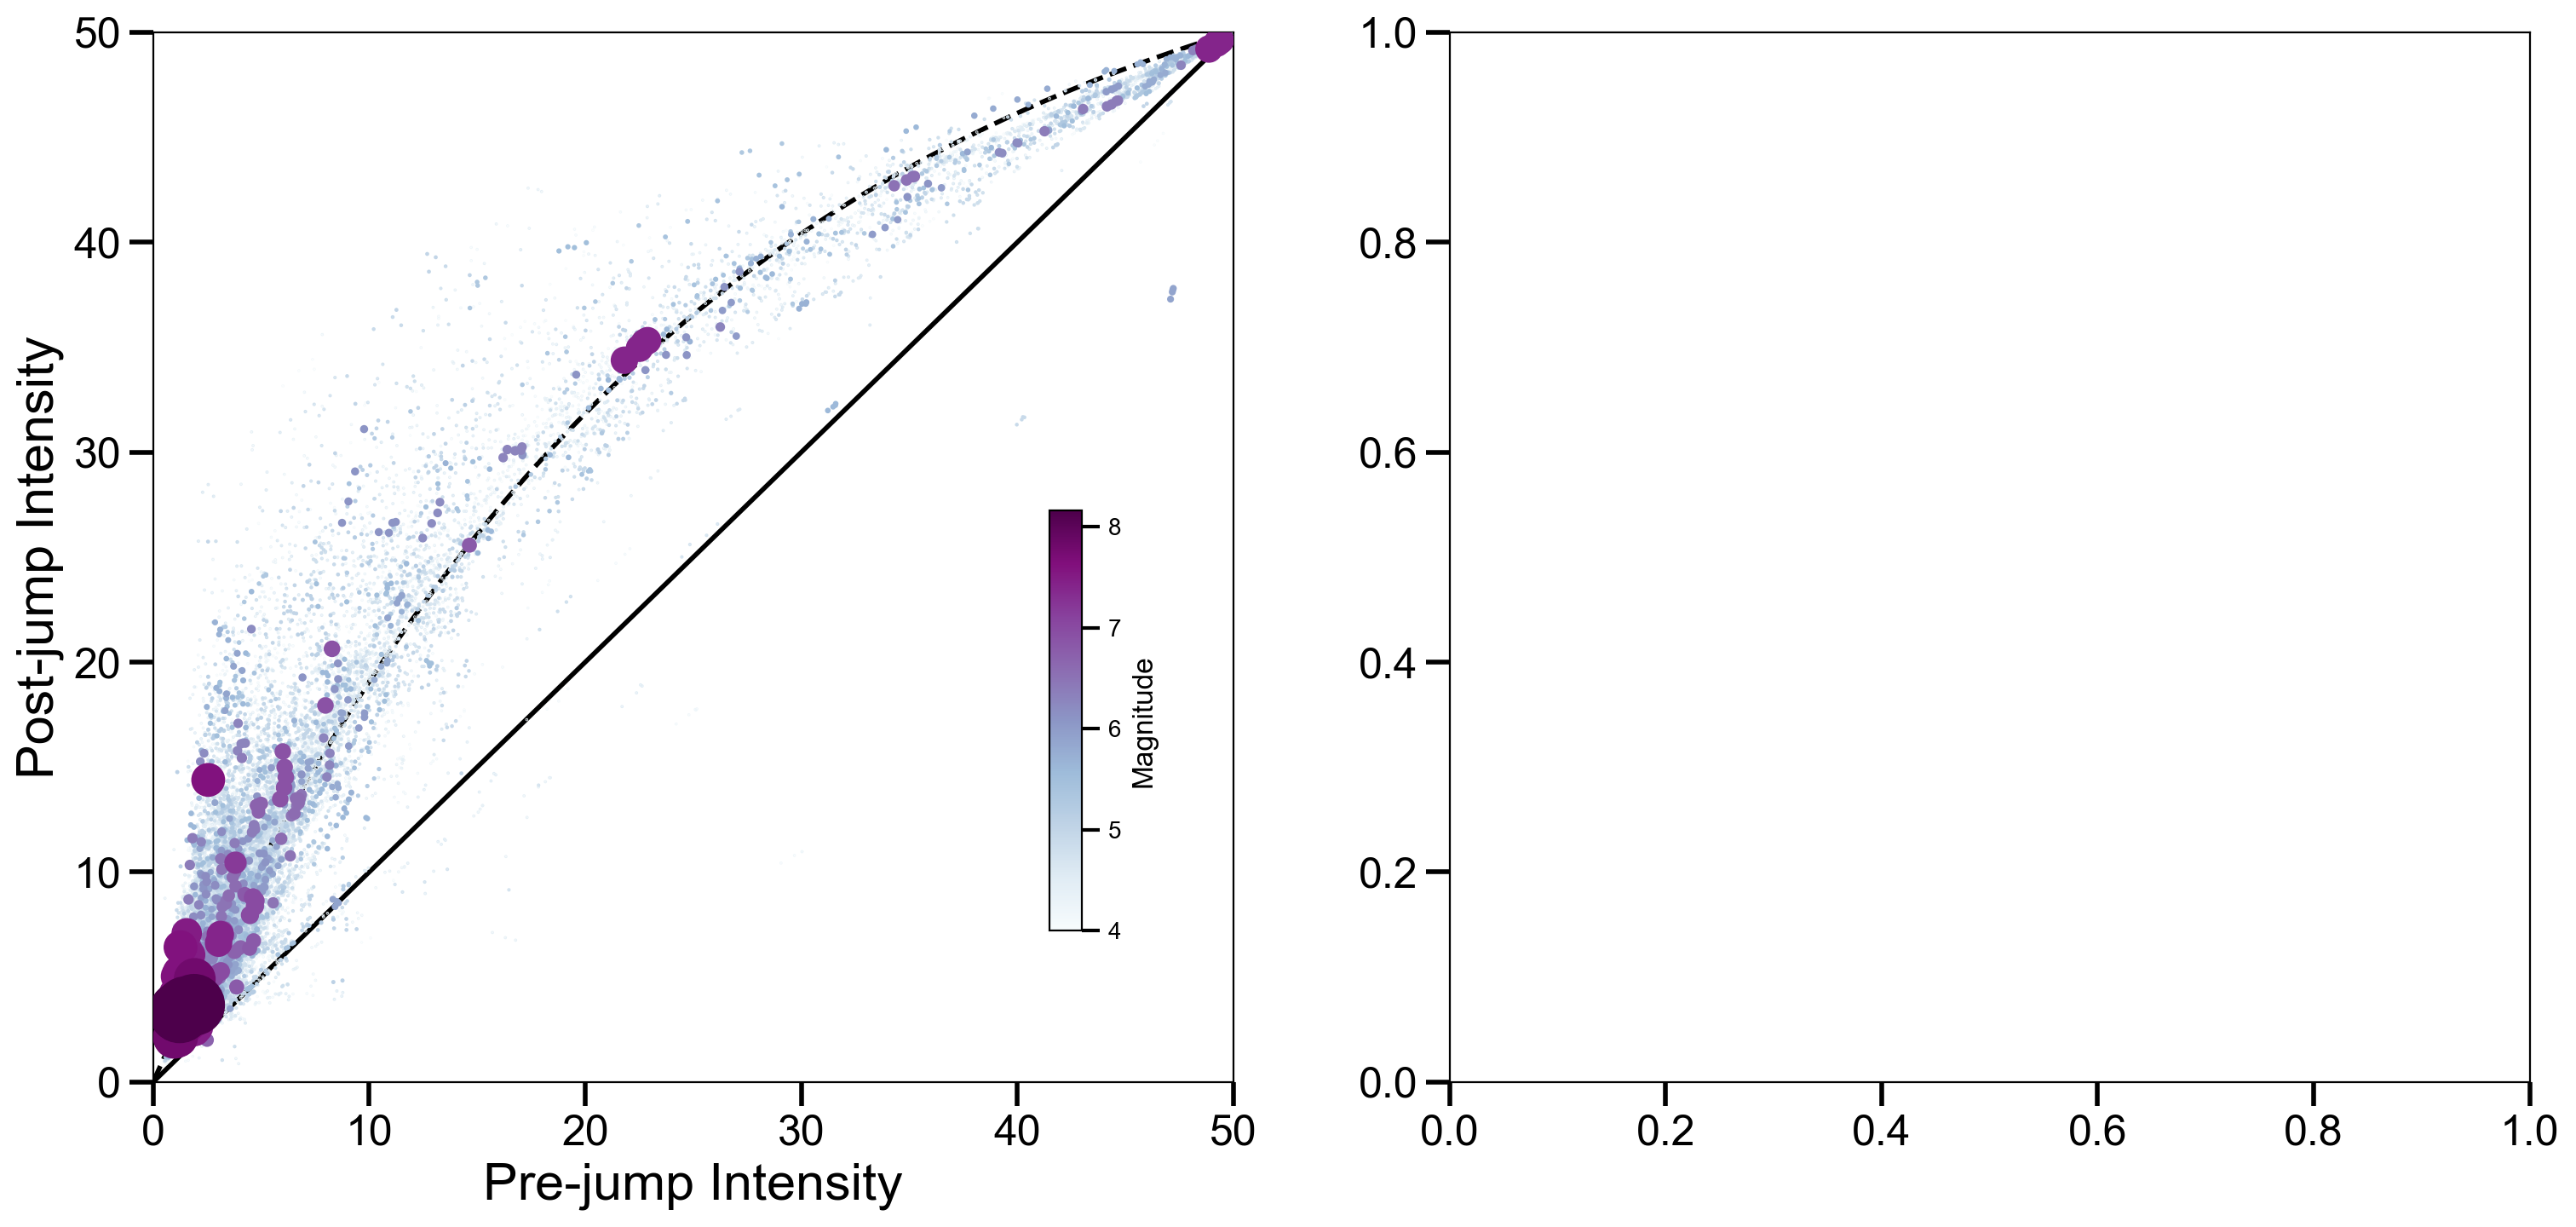

In [94]:
fig, axes = plt.subplots(1, 2, figsize=(18,8), dpi=200, gridspec_kw={'width_ratios': [1, 1]})
obj1 = axes[0].scatter(all_pre_lambdas[all_sorted], all_post_lambdas[all_sorted], 
                       s=all_sizes[all_sorted], c=all_mags[all_sorted], cmap='BuPu', vmin=4.0, zorder=10)
axes[0].set_xlabel('Pre-jump Intensity')
axes[0].set_ylabel('Post-jump Intensity')
axes[0].grid(False)

axes[0].plot([0, 50], [0, 50], 'k-', lw=2)
axes[0].set_xlim([0, 50])
axes[0].set_ylim([0, 50])

x_arr = np.linspace(0, 50, 1000)
# y_arr = 50 * (1 - (x_arr/50-1) ** 2)
# y_arr = x_arr + x_arr * (50 - x_arr) / 75
for alpha in [0.04]:  # [0.05, 0.025]
    y_arr = 50 * (1 - np.exp(-alpha * x_arr)) / (1 - np.exp(-alpha * 50))
    axes[0].plot(x_arr, y_arr, 'k--', lw=2, alpha=1, zorder=1)

cax = inset_axes(axes[0], width="3%", height="40%", loc='lower right', borderpad=4)
cbar = fig.colorbar(obj1, cax=cax, orientation='vertical')
cbar.set_label('Magnitude', fontsize=12)
cbar.ax.tick_params(labelsize=10)
cbar.ax.tick_params(length=7.5, width=1.5)

In [95]:
# Read analyzed data
# cur_path = './JP_no_mag/'
cur_path = './JP_mag4_2dcnf/'

all_times, all_locs, all_mags, all_pre_lambdas, all_post_lambdas = read_lambda_npz(
    [f'{cur_path}/lambda_train_1.npz', f'{cur_path}/lambda_train_2.npz',
     f'{cur_path}/lambda_val.npz', f'{cur_path}/lambda_test.npz'])

# Size of dots
all_sizes = stretch_array(all_mags, -0.6, 1.4)
all_sizes = (10 ** all_sizes) ** 2

# Order of plotting dots
all_sorted = np.argsort(all_sizes)

In [96]:
obj2 = axes[1].scatter(all_pre_lambdas[all_sorted], all_post_lambdas[all_sorted], 
                       s=all_sizes[all_sorted], c=all_mags[all_sorted], cmap='BuPu', vmin=4.0, zorder=10)
axes[1].set_xlabel('Pre-jump Intensity')
axes[1].grid(False)

axes[1].plot([0, 50], [0, 50], 'k-', lw=2)
axes[1].set_xlim([0, 50])
axes[1].set_ylim([0, 50])

for alpha in [0.05, 0.025]:
    y_arr = 50 * (1 - np.exp(-alpha * x_arr)) / (1 - np.exp(-alpha * 50))
    axes[1].plot(x_arr, y_arr, 'k--', lw=2, alpha=1, zorder=1)

plt.tight_layout(w_pad=2.5)
fig.savefig('./Figures/lambda_jumps.png', dpi=200, bbox_inches='tight', pad_inches=0.05)

<Figure size 640x480 with 0 Axes>

## Computational complexity

In [119]:
txtfiles = ['./npz_prob_gpu/run_1/run_1.txt', './npz_prob_gpu/run_2/run_2.txt']
N, T, t_new, t_old = parse_testfiles(txtfiles)

t_new = t_new * 2500 / N
t_old = t_old * 2500 / N

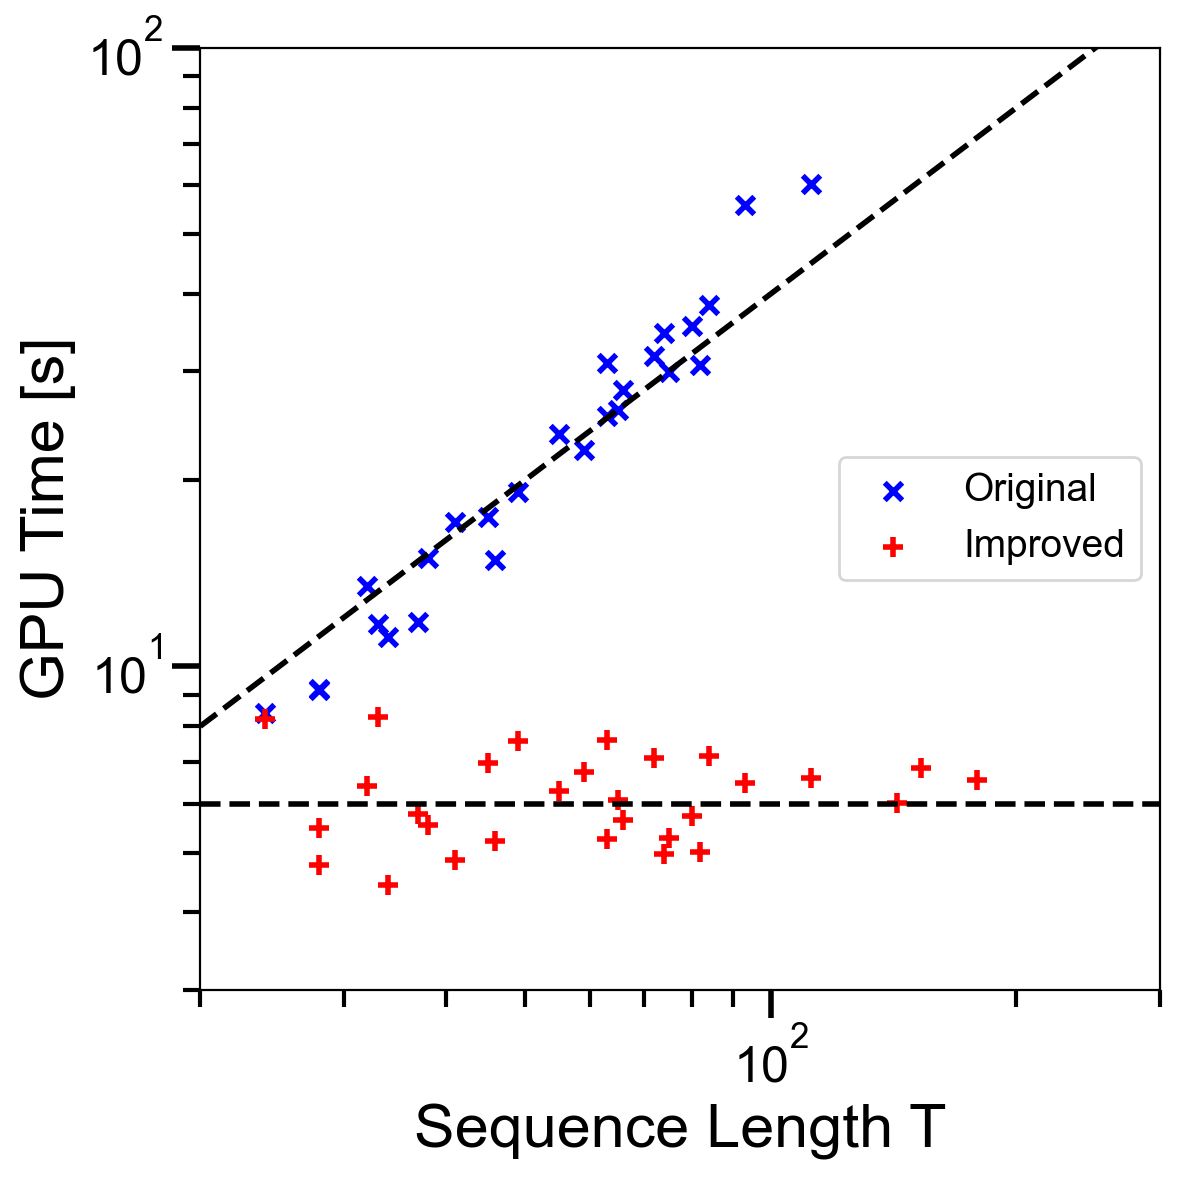

In [122]:
fig, ax = plt.subplots(figsize=(6,6), dpi=200)
ax.scatter(T, t_old, s=40, c='b', marker='x', lw=2, label='Original')
ax.scatter(T, t_new, s=50, c='r', marker='+', lw=2, label='Improved')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Sequence Length T')
ax.set_ylabel('GPU Time [s]')
ax.grid(False)
ax.legend(loc='right', fontsize=14)

# ax.tick_params(axis='both', which='both', bottom=False, top=False,
#                left=False, right=False, labelbottom=False, labelleft=False)

x_arr = np.linspace(20, 300, 1000)
# y_arr = 10 * x_arr   # CPU
y_arr = 0.4 * x_arr  # GPU
ax.plot(x_arr, y_arr, 'k--', lw=2, zorder=1)
ax.plot([20, 300], [6, 6], 'k--', lw=2, zorder=1)

ax.set_xlim([20, 300])
# ax.set_ylim([20, 6000])  # CPU
ax.set_ylim([3, 100])  # GPU
plt.tight_layout()
fig.savefig('./Figures/gpu_time.png', dpi=200, bbox_inches='tight', pad_inches=0.05)

## Spatial distribution

In [57]:
npz_files = ['./npz_prob_gpu/run_1/seq287_test5_new.npz', './npz_prob_gpu/run_1/seq287_test5_old.npz']

data_new = np.load(npz_files[0])
data_old = np.load(npz_files[1])

In [58]:
# MAPE
MAPE = np.average(np.abs( (data_new['logp'] - data_old['logp']) / data_old['logp'] ))
RMSE = np.sqrt(np.average((data_new['logp'] - data_old['logp']) ** 2))

print(f'MAPE: {MAPE * 100} %')
print(f'RMSE: {RMSE}')

MAPE: 0.1619087066501379 %
RMSE: 0.557887613773346


In [134]:
import glob

npz_dir = './npz_seq600_gpu/'
npz_files = glob.glob(os.path.join(npz_dir, '*.npz'))

geo_range = (122.5, 150, 25, 45)
inset_map = True

for npz_file in npz_files:
    
    data_new = np.load(npz_file)
    logp = data_new['logp']
    
    if inset_map:
        map_img = plt.imread('../my_results/assets/Japan_basemap.png')
        fig, ax = plt.subplots(figsize=(10, 10 * map_img.shape[0] / map_img.shape[1]))
        ax.imshow(map_img, zorder=0, extent=geo_range)

    else:
        fig, ax = plt.subplots(figsize=(10, 10))
        
    ax.pcolormesh(data_new['X'], data_new['Y'], np.exp(logp), alpha=0.7, shading='gouraud', cmap='Reds',
                  aa=False, ec='Face', lw=0.0001)
    ax.scatter(data_new['event_locs'][:, 0], data_new['event_locs'][:, 1], s=20, alpha=1.0, marker="x", color="k")

    ax.set_xlim(geo_range[0], geo_range[1])
    ax.set_ylim(geo_range[2], geo_range[3])
    ax.axis('off')
    plt.tight_layout()

    fig.savefig(f'{npz_file[:-4]}.pdf', dpi=200, bbox_inches='tight', pad_inches=0.05)
    plt.close(fig)

In [135]:
import glob

npz_dir = './npz_seq449_gpu/'
npz_files = glob.glob(os.path.join(npz_dir, '*.npz'))
npz_files = sorted(npz_files)

geo_range = (122.5, 150, 25, 45)
inset_map = True

for npz_file in list(npz_files[::2]):
    
    data_new = np.load(npz_file)
    logp = data_new['logp']
    
    if inset_map:
        map_img = plt.imread('../my_results/assets/Japan_basemap.png')
        fig, ax = plt.subplots(figsize=(10, 10 * map_img.shape[0] / map_img.shape[1]))
        ax.imshow(map_img, zorder=0, extent=geo_range)

    else:
        fig, ax = plt.subplots(figsize=(10, 10))
        
    ax.pcolormesh(data_new['X'], data_new['Y'], np.exp(logp), alpha=0.7, shading='gouraud', cmap='Reds',
                  aa=False, ec='Face', lw=0.0001)
    ax.scatter(data_new['event_locs'][:, 0], data_new['event_locs'][:, 1], s=20, alpha=1.0, marker="x", color="k")

    ax.set_xlim(geo_range[0], geo_range[1])
    ax.set_ylim(geo_range[2], geo_range[3])
    ax.axis('off')
    plt.tight_layout()

    fig.savefig(f'{npz_file[:-4]}.pdf', dpi=200, bbox_inches='tight', pad_inches=0.05)
    plt.close(fig)

In [123]:
npz_files = './npz_seq600_gpu/snapshot9.npz'
data_new = np.load(npz_files)

In [124]:
# Stretch array
# logp = stretch_array(data_new['logp'], -40, 20)

# Not stretched
logp = data_new['logp']

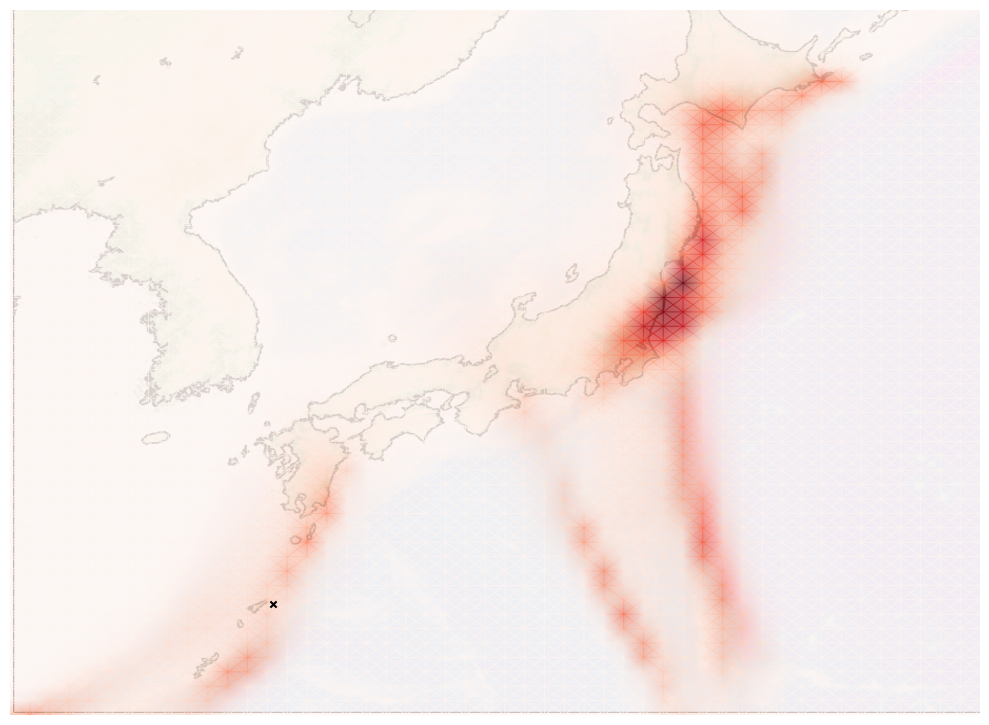

In [125]:
geo_range = (122.5, 150, 25, 45)
inset_map = True

if inset_map:
    map_img = plt.imread('../my_results/assets/Japan_basemap.png')
    fig, ax = plt.subplots(figsize=(10, 10 * map_img.shape[0] / map_img.shape[1]))
    ax.imshow(map_img, zorder=0, extent=geo_range)
    
else:
    fig, ax = plt.subplots(figsize=(10, 10))

# Plot difference in logp
# ax.contourf(data_new['X'], data_new['Y'], np.exp(logp), levels=10, alpha=0.7, cmap='Reds')
ax.pcolormesh(data_new['X'], data_new['Y'], np.exp(logp), alpha=0.7, shading='gouraud', cmap='Reds',
              aa=False, ec='Face', lw=0.0001)
ax.scatter(data_new['event_locs'][:, 0], data_new['event_locs'][:, 1], s=20, alpha=1.0, marker="x", color="k")

ax.set_xlim(geo_range[0], geo_range[1])
ax.set_ylim(geo_range[2], geo_range[3])
ax.axis('off')
plt.tight_layout()

# fig.savefig('./Figures/snapshot2.pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)

## Earthquake catalog

## Old spatial distribution

In [24]:
geo_range = (122.5, 150, 25, 45)

N = 20
x = np.linspace(geo_range[0], geo_range[1], N)
y = np.linspace(geo_range[2], geo_range[3], N)
s = np.stack([x, y], axis=1)

X, Y = np.meshgrid(s[:, 0], s[:, 1])
S = np.stack([X.reshape(-1), Y.reshape(-1)], axis=1)
S = torch.tensor(S).to(device)

S_mag = torch.tensor([4.3]).expand(S.shape[0], 1).to(device).float()
S = torch.cat([S, S_mag], axis=1)
S = S.float()

S = (S - dataset.S_mean.to(S)) / dataset.S_std.to(S)
S = S[:, :args.spatial_dim]

In [39]:
# Get spatial log probability function handles

# Time samples
tq = create_time_samples(event_times, t0, t1, 0).numpy()
tq = np.concatenate(tq[:10, :-1], axis=0)
tq = tq + 0.01
tq = np.arange(1, 4.1, 0.2)

# tq = np.array([0, 12, 17])

loglik_fn = [model.spatial_conditional_logprob_fn(t, event_times[event_times<t], 
                                                  tpp_locations[event_times<t], t0, t1) for t in tq]

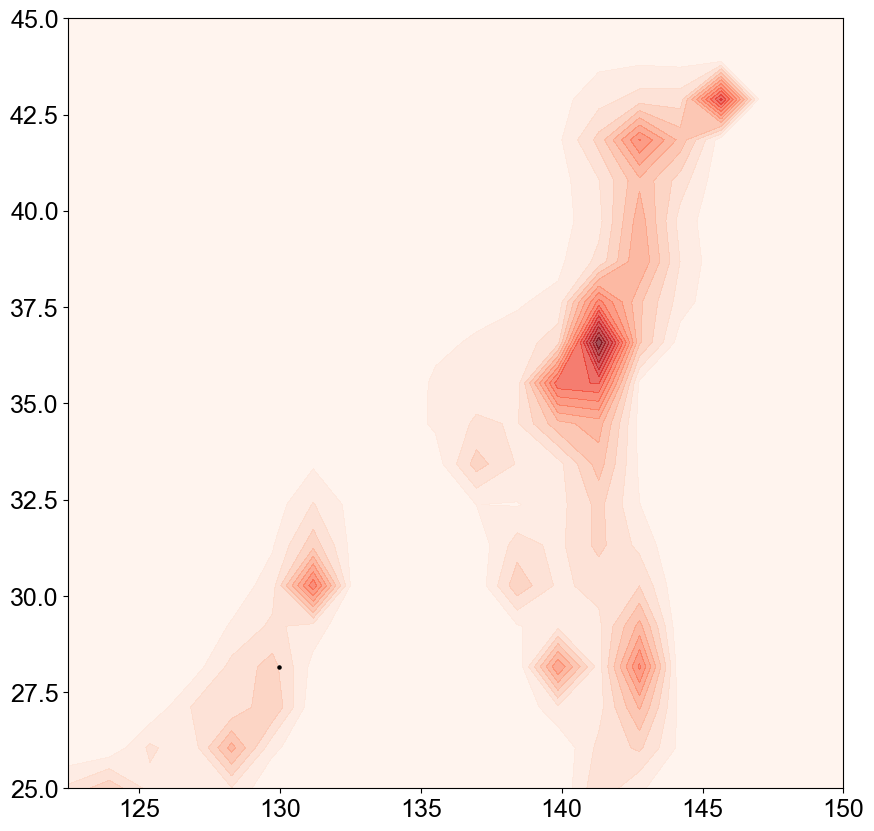

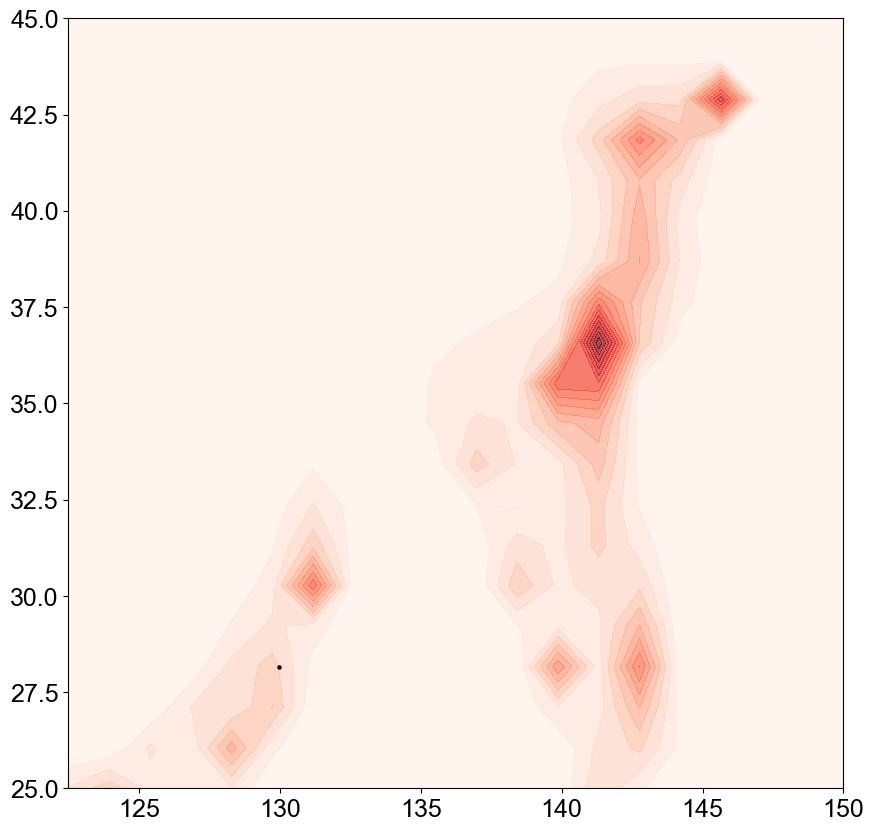

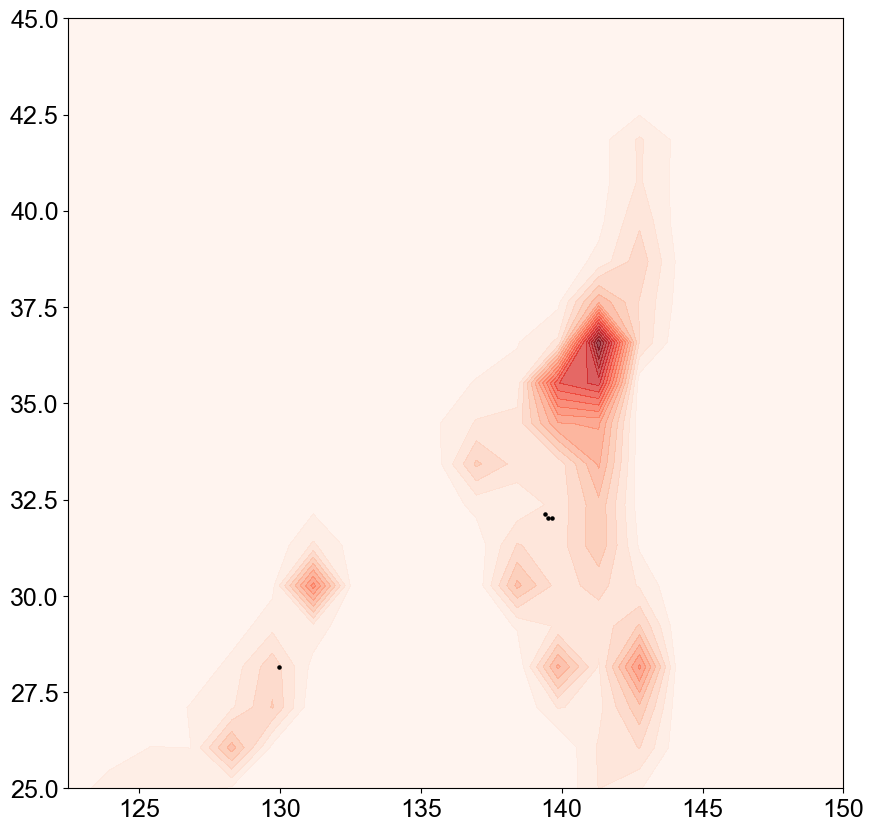

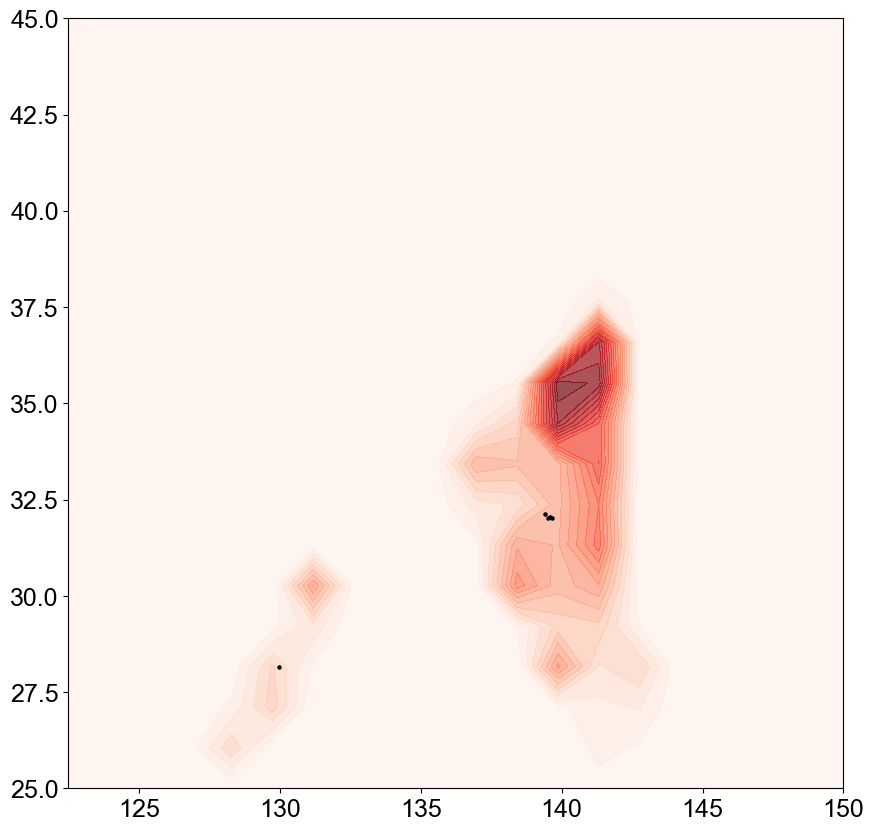

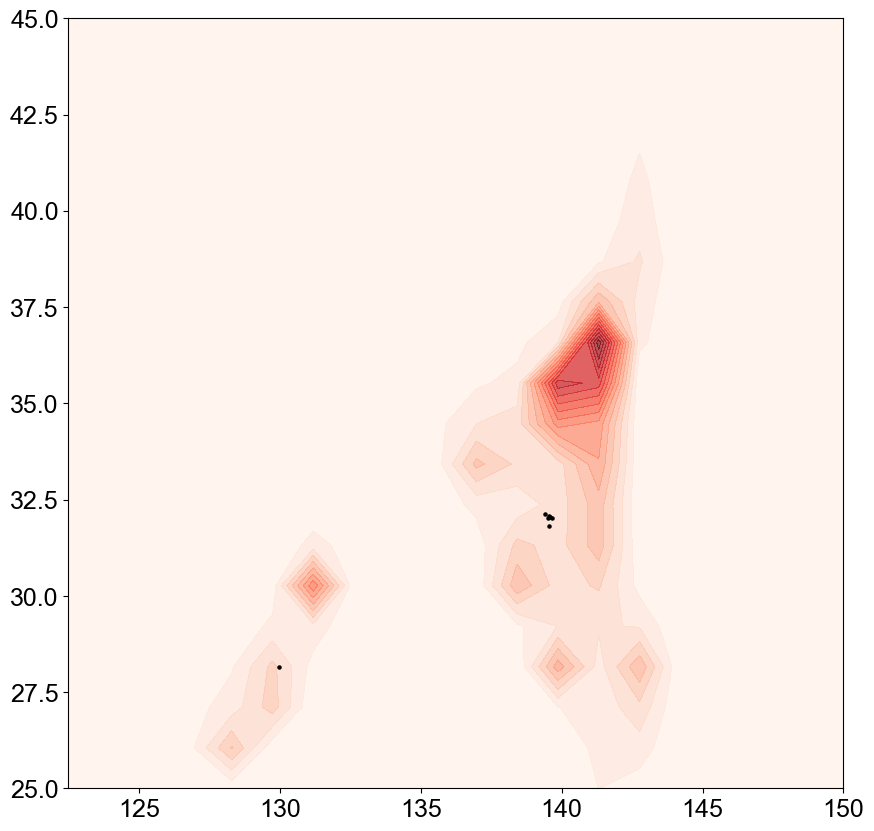

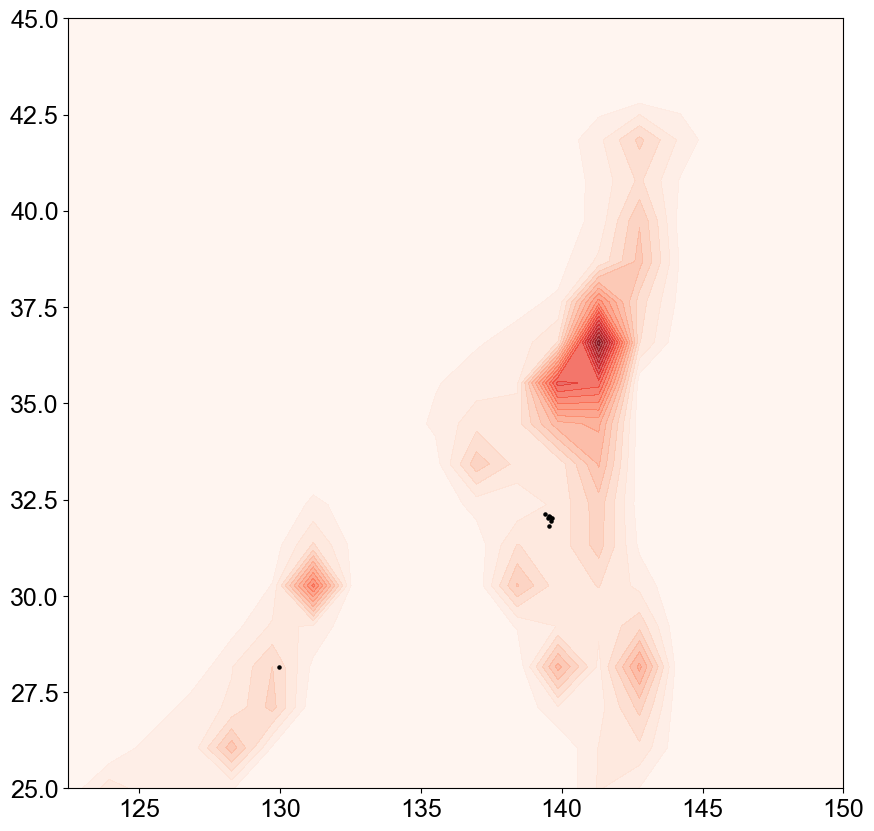

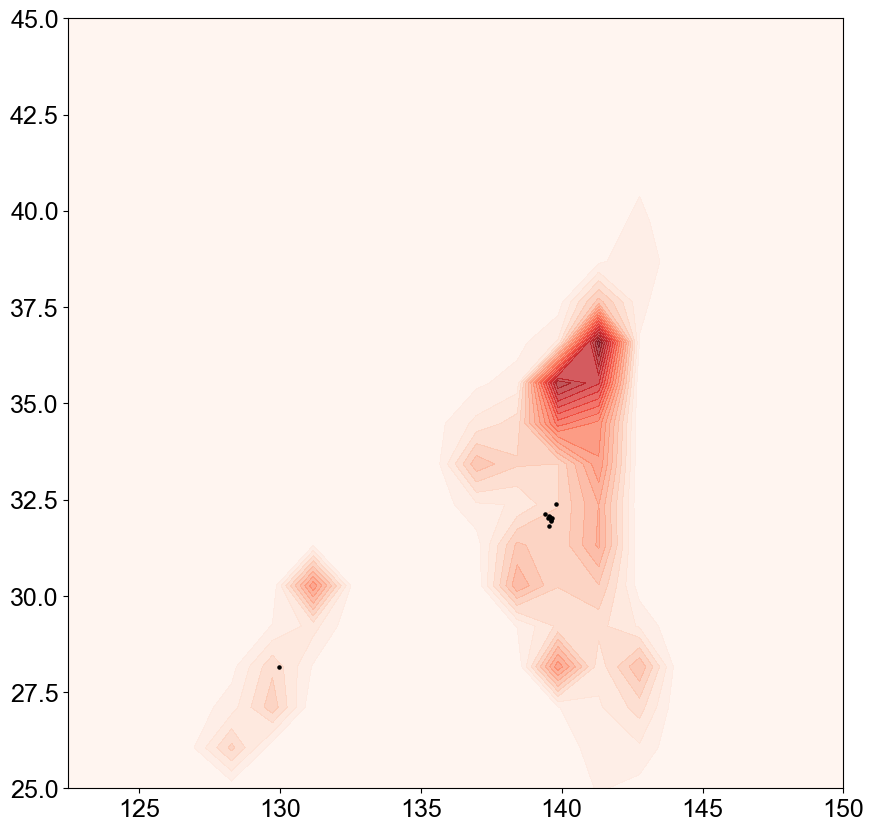

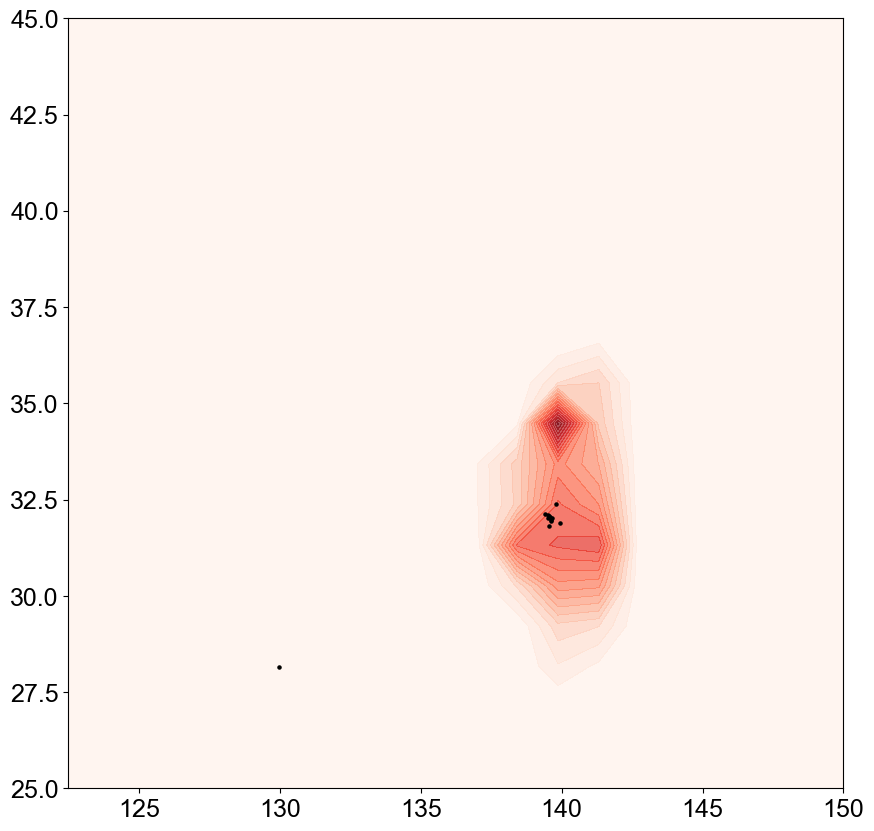

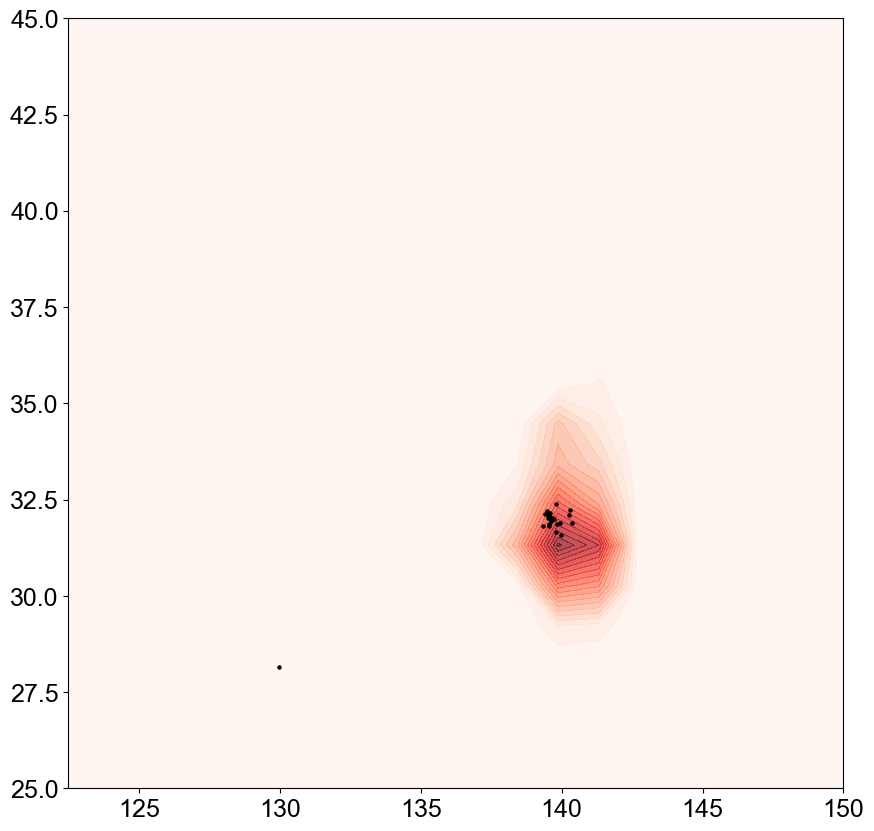

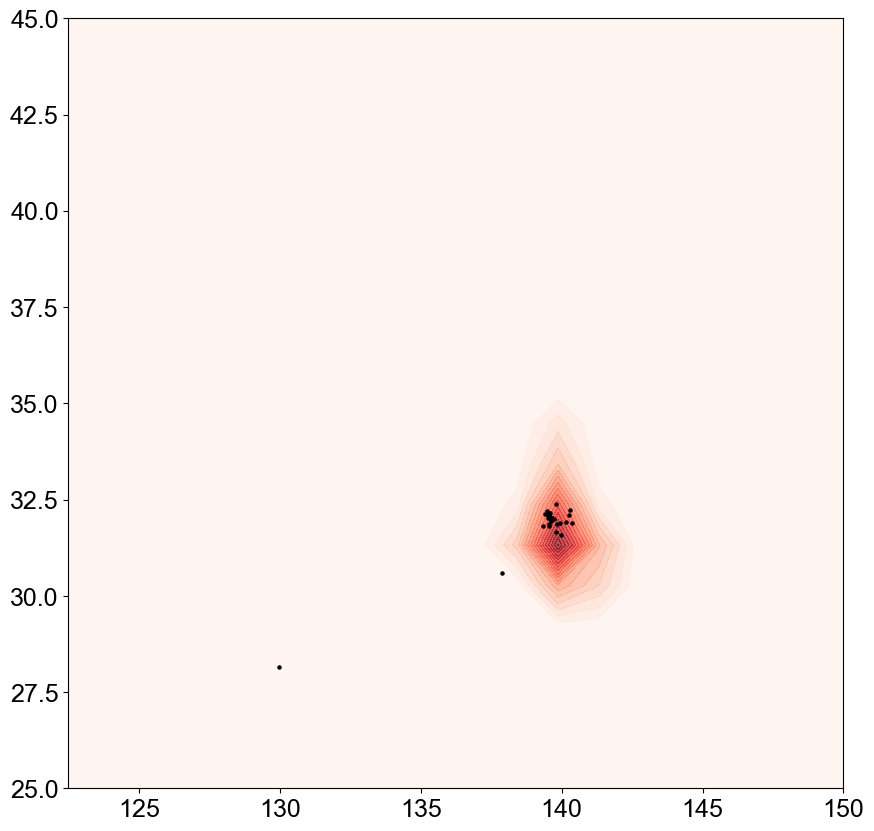

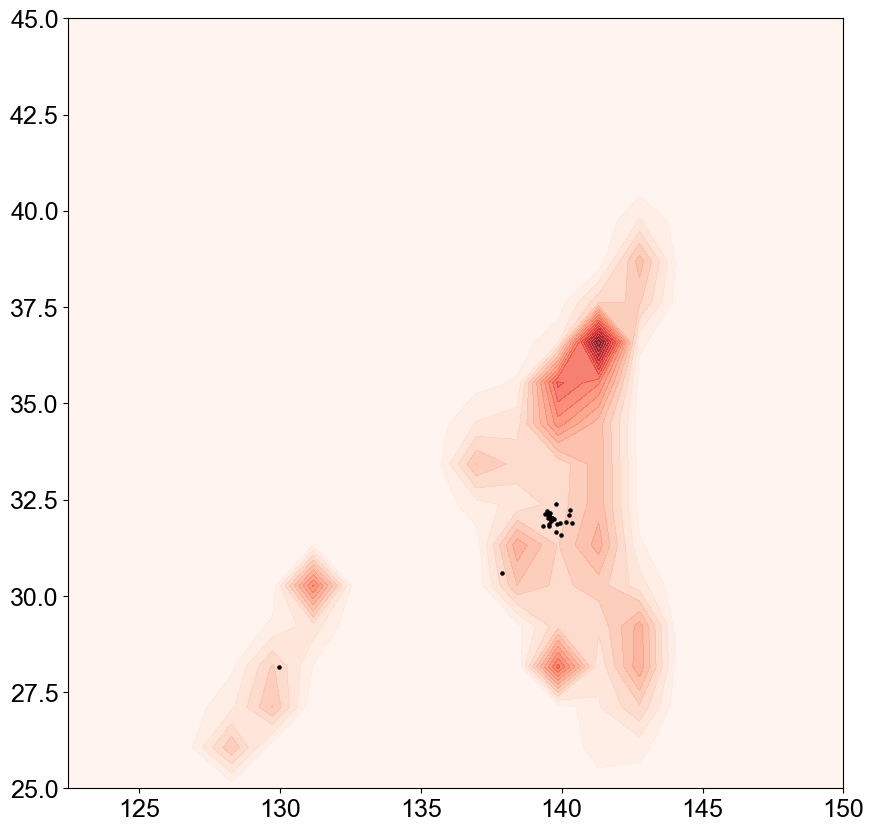

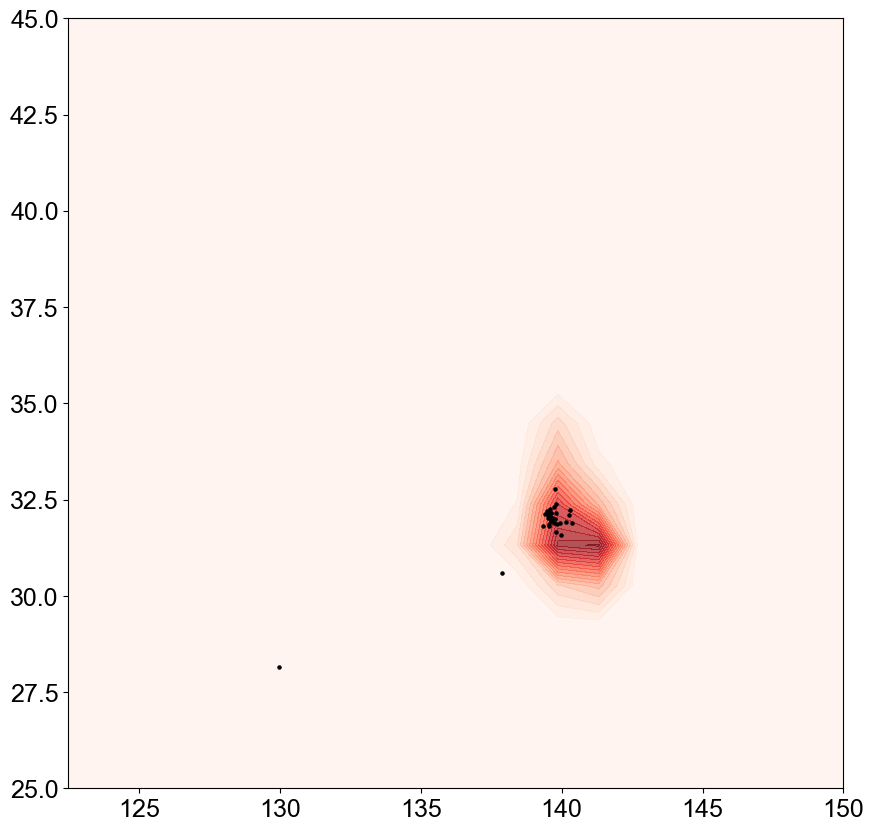

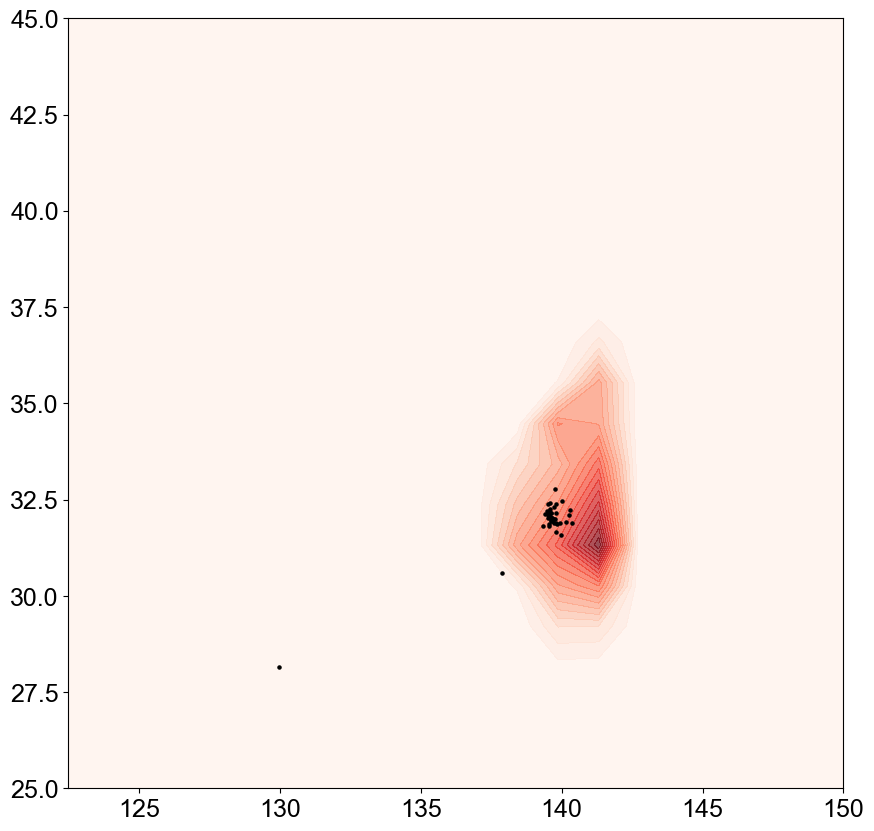

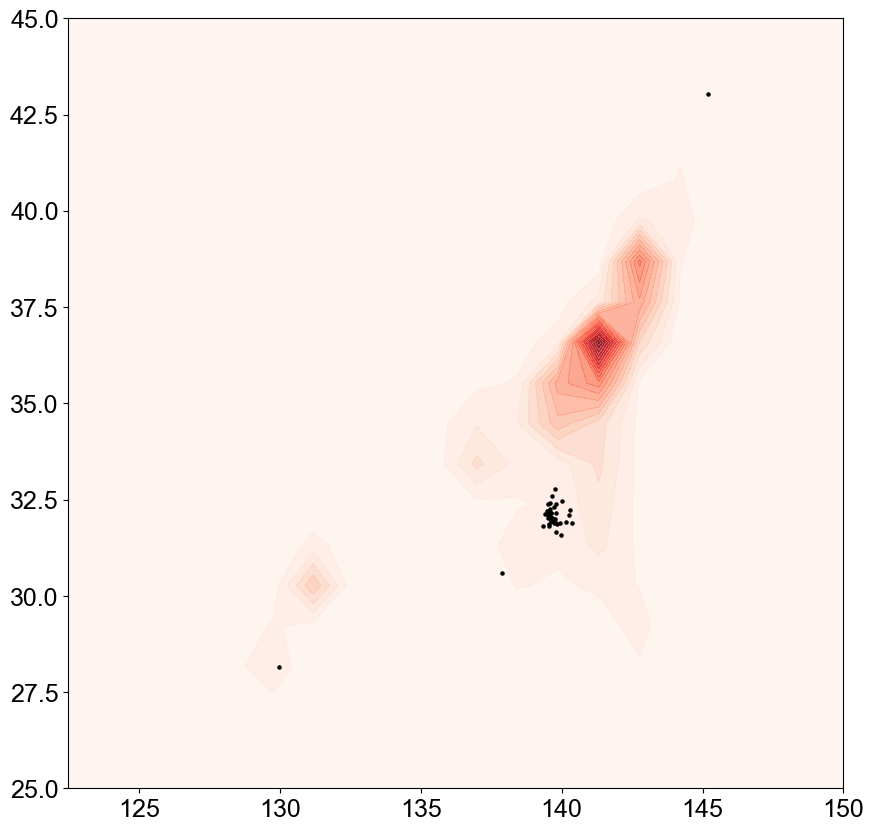

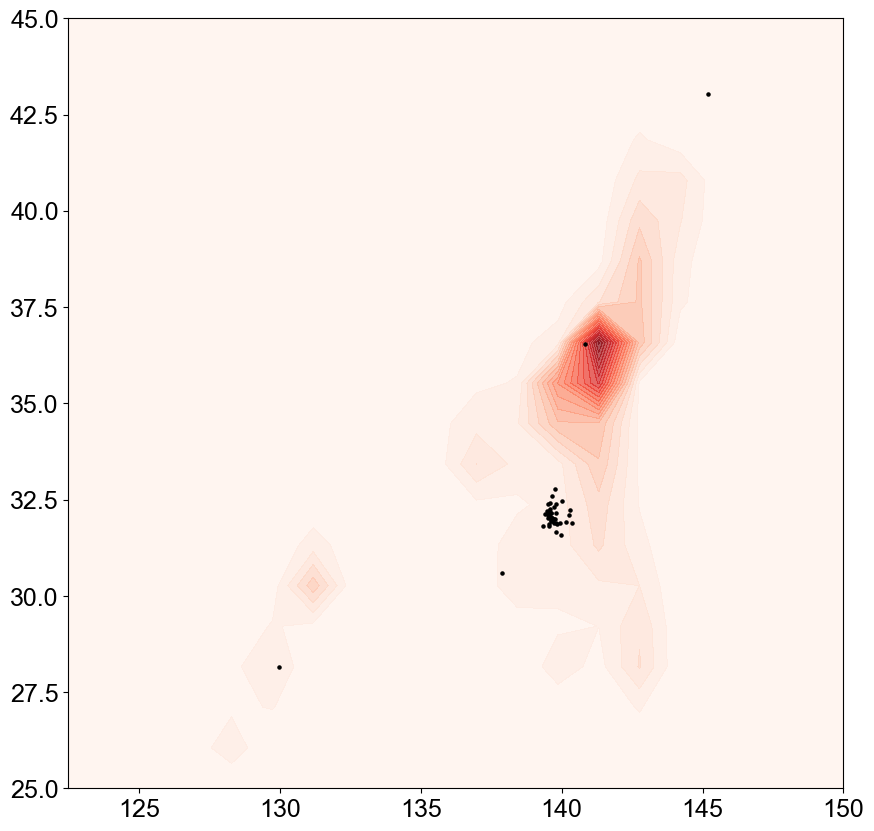

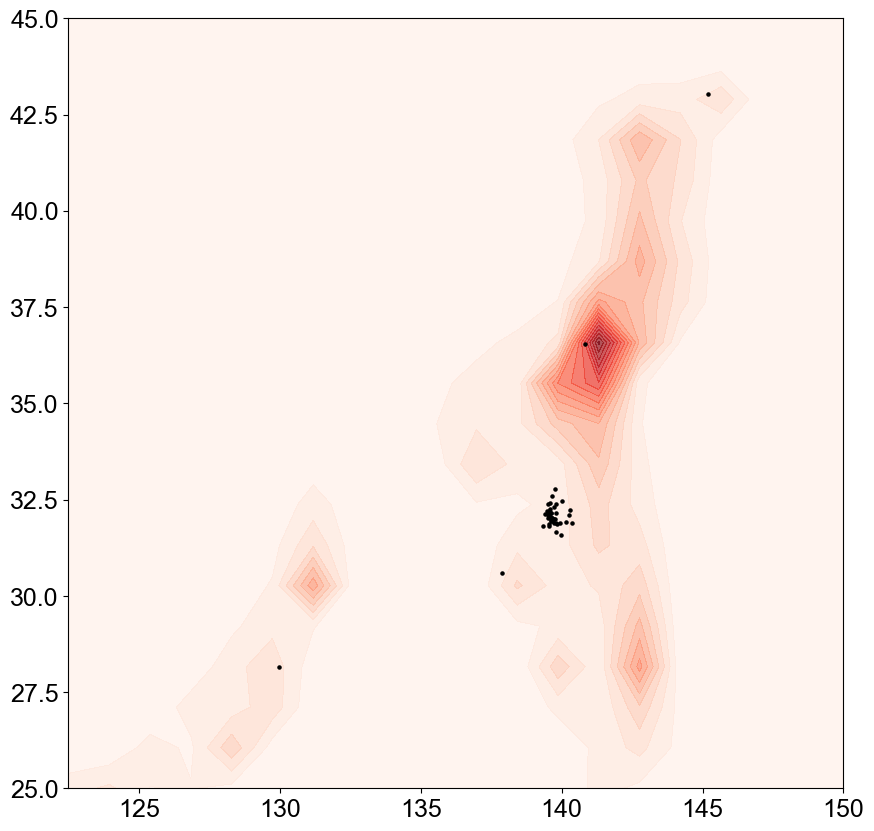

In [40]:
for i in range(len(tq)):
    time_mask = (event_times < tq[i])
    
    logp = loglik_fn[i](S)
    Z = logp.exp().detach().cpu().numpy().reshape(N, N)
    
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.contourf(X, Y, Z, levels=20, alpha=0.7, cmap='Reds')
    ax.scatter(real_event_locs[time_mask, 0], real_event_locs[time_mask, 1], s=20, alpha=1.0, marker=".", color="k")
    
    ax.set_xlim(geo_range[0], geo_range[1])
    ax.set_ylim(geo_range[2], geo_range[3])
    fig

Test 0, Sequence 466, N 400, T 66, New method 13.45 s, Old method 375.98 s

Test 1, Sequence 208, N 400, T 38, New method 11.51 s, Old method 118.43 s

In [80]:
npts_interval = 4
time_samples = create_time_samples(event_times, t0, t1, npts_interval)
tq_arr = time_samples[:, :-1].reshape(-1)